<a href="https://colab.research.google.com/github/jofmorenore/OPS/blob/main/Poisson_eventos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de eventos

Con los datos históricos de cada evento en salud pública de ETVs, se obtiene un número esperado, se busca determinar inicialmente cuáles eventos son de bajas (altas) frecuencias.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA


from sklearn import metrics

In [4]:
path = '/content/drive/MyDrive/OPS/Datos/TABLERO_CONTROL_SE_24_2024.xlsx'
wb = pd.ExcelFile(path)
wb.sheet_names

['Hoja1',
 'casosporeventoporsemana2016',
 'DEFINIR EVENTOS',
 'Dates',
 'Datadep',
 'Model1(alta frecuencia)',
 'Graph_1',
 'DENGUE',
 'Model2 (baja frecuencia)',
 'Graph_2',
 'Sarampión']

In [5]:
df_eventos = pd.read_excel(path, sheet_name='Datadep')
print(df_eventos.shape)
df_eventos.head()

(577, 73)


año  Semana  Sem      Fecha Sem_Año ACCIDENTE OFIDICO  \
0  2013.0     1.0  1.0 2013-01-01   20131                98   
1  2013.0     2.0  2.0 2013-01-06   20132                98   
2  2013.0     3.0  3.0 2013-01-13   20133                93   
3  2013.0     4.0  4.0 2013-01-20   20134                74   
4  2013.0     5.0  5.0 2013-01-27   20135                84   

  AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA  \
0                                               1692             
1                                               1873             
2                                               1872             
3                                               1924             
4                                               1804             

  BAJO PESO AL NACER CÁNCER DE LA MAMA Y CUELLO UTERINO  \
0                156                                  0   
1                214                                  0   
2                271                                  0   
3                249                                  0   
4                264                                  0   

  CÁNCER EN MENORES DE 18 AÑOS  ... Unnamed: 63 Unnamed: 64 Unnamed: 65  \
0                           17  ...         NaN         NaN         NaN   
1                            7  ...         NaN         NaN         NaN   
2                           15  ...         NaN         NaN         NaN   
3                           12  ...         NaN         NaN         NaN   
4                           12  ...         NaN         NaN         NaN   

  Unnamed: 66 Unnamed: 67 Unnamed: 68 Unnamed: 69 Unnamed: 70 Unnamed: 71  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 72  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 73 columns]

In [6]:
df_eventos.drop(['Unnamed: 61', 'Unnamed: 62',
                 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66',
                 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70',
                 'Unnamed: 71', 'Unnamed: 72'],axis = 1, inplace = True)

In [7]:
df_eventos.columns

Index(['año', 'Semana', 'Sem', 'Fecha', 'Sem_Año', 'ACCIDENTE OFIDICO',
       'AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA',
       'BAJO PESO AL NACER', 'CÁNCER DE LA MAMA Y CUELLO UTERINO',
       'CÁNCER EN MENORES DE 18 AÑOS', 'CHAGAS', 'CHIKUNGUNYA',
       'DEFECTOS CONGENITOS', 'DENGUE', 'DENGUE GRAVE',
       'DESNUTRICIÓN AGUDA EN MENORES DE 5 AÑOS',
       'ENFERMEDAD DIARREICA AGUDA POR ROTAVIRUS',
       'ENFERMEDADES HUERFANAS - RARAS', 'ESI - IRAG (VIGILANCIA CENTINELA)',
       'EVENTO ADVERSO GRAVE POSTERIOR A LA VACUNACIÒN', 'EXPOSICIÓN A FLÚOR',
       'FIEBRE AMARILLA', 'FIEBRE TIFOIDEA Y PARATIFOIDEA',
       'HEPATITIS B, C Y COINFECCIÓN HEPATITIS B Y DELTA',
       'INFECCION RESPIRATORIA AGUDA GRAVE IRAG INUSITADA',
       'INTENTO DE SUICIDIO', 'INTOXICACIONES', 'LEISHMANIASIS CUTANEA',
       'LEISHMANIASIS MUCOSA', 'LEISHMANIASIS VISCERAL', 'LEPRA',
       'LEPTOSPIROSIS', 'LESIONES DE CAUSA EXTERNA',
       'LESIONES POR PÓLVORA PIROTÉCNICA'

In [8]:
df_eventos = df_eventos[~df_eventos['Semana'].isna()].reset_index(drop = True)
df_eventos.shape

(546, 61)

In [9]:
df_eventos['Semana'] = [str(int(i)) for i in df_eventos['Semana']]

# Caracterización de eventos

+ Vigilancia en salud pública ETVs: 'DENGUE', 'DENGUE GRAVE','MALARIA'
+ Fuera de escala: 'CHIKUNGUNYA', 'INFECCION RESPIRATORIA AGUDA GRAVE IRAG INUSITADA', 'ZIKA'
+ Atípicos por lo alto: 'LEPTOSPIROSIS', 'SARAMPION + RUBEOLA', 'VIH/SIDA/MORTALIDAD POR SIDA', 'LESIONES DE CAUSA EXTERNA'
+ Atípicos por lo bajo: 'BAJO PESO AL NACER', 'DEFECTOS CONGENITOS', 'MORTALIDAD PERINATAL Y NEONATAL TARDÍA'
+ Escala continua: 'FIEBRE AMARILLA','LEISHMANIASIS VISCERAL', 'LEPRA', 'TETANOS ACCIDENTAL', 'TETANOS NEONATAL'
+ Proporciones: 'TETANOS NEONATAL', 'TIFUS ENDEMICO TRASMITIDO POR PULGAS', 'TIFUS EPIDEMICO TRANSMITIDO POR PIOJOS'


In [10]:
# En esta parte se crea el df con la serie de promedio (mediana) de cada semana para cada evento
## regla: cuando el promedio este fuera de (la caja) Q1 y Q3, entonces utilizar la mediana
#def quartiles(x):
#    return pd.Series([x.quantile(0.25), x.quantile(0.5), x.quantile(0.75)], index=['Q1', 'Q2', 'Q3'])
dict_eventos = {}
for i in df_eventos.columns[5:]:
  df_grouped = df_eventos[['Semana',i]].groupby('Semana').agg({i:['mean', lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75)]}).reset_index()
  df_grouped['Semana'] = pd.to_numeric(df_grouped['Semana'])
  df_grouped = df_grouped.sort_values(by='Semana').reset_index(drop = True)
  df_grouped.columns = ['Semana', 'mean', 'Q1','Q2', 'Q3']
  df_grouped['serie'] = np.where((df_grouped['mean']<df_grouped['Q1']) | (df_grouped['mean']>df_grouped['Q3']), df_grouped['Q2'], df_grouped['mean'])
  df_grouped['Semana'] = df_grouped['Semana'].astype('str')
  dict_eventos[i] = df_grouped

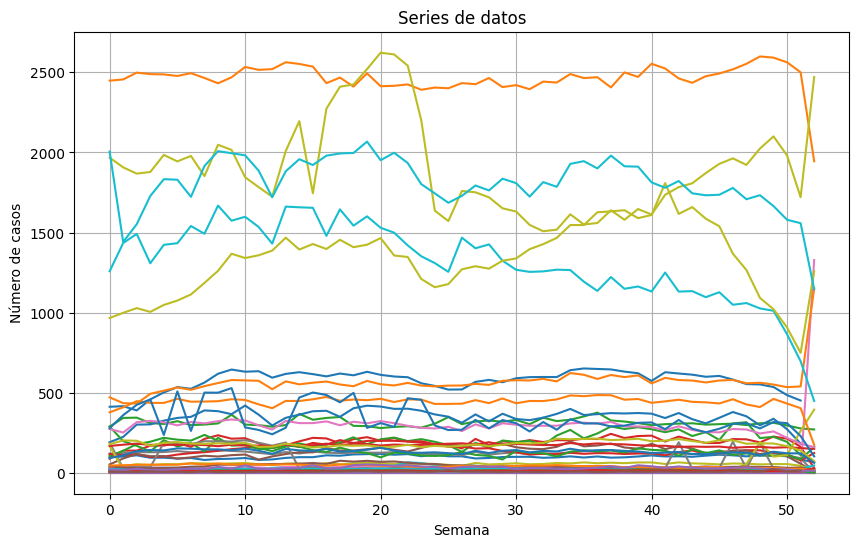

In [11]:
plt.figure(figsize=(10, 6))

# Graficar cada serie del diccionario
for key, df in dict_eventos.items():
    plt.plot(df['serie'], label=key)

# Configurar el gráfico
plt.xlabel('Semana')
plt.ylabel('Número de casos')
plt.title('Series de datos')
#plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [12]:
df_promedio = pd.DataFrame()
for key, df in dict_eventos.items():
  df_promedio = pd.concat([df_promedio, df['serie']], axis = 1)

In [13]:
df_promedio.columns = dict_eventos.keys()
df_promedio = df_promedio.reset_index(drop = False)
df_promedio = df_promedio.rename(columns = {'index':'semana'})
df_promedio['semana'] = df_promedio['semana'] + 1
df_promedio

semana ACCIDENTE OFIDICO  \
0        1              98.0   
1        2        100.727273   
2        3        108.636364   
3        4         93.545455   
4        5         93.909091   
5        6         88.545455   
6        7         91.818182   
7        8         79.727273   
8        9         85.727273   
9       10         87.181818   
10      11         91.818182   
11      12         80.090909   
12      13         82.909091   
13      14         92.636364   
14      15         97.090909   
15      16              97.0   
16      17        108.636364   
17      18        106.272727   
18      19        114.181818   
19      20        116.090909   
20      21        117.818182   
21      22        112.454545   
22      23        116.090909   
23      24        103.181818   
24      25             111.5   
25      26             102.5   
26      27             102.4   
27      28              89.0   
28      29              92.1   
29      30              97.9   
30      31              99.2   
31      32              99.6   
32      33              93.4   
33      34              95.6   
34      35             102.2   
35      36              94.8   
36      37             101.5   
37      38              94.1   
38      39              96.1   
39      40             101.5   
40      41             107.8   
41      42             101.6   
42      43             102.6   
43      44              99.4   
44      45             106.6   
45      46             112.7   
46      47             108.6   
47      48             102.3   
48      49             108.5   
49      50             106.3   
50      51             103.0   
51      52              83.4   
52      53              64.0   

   AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA  \
0                                         2448.181818             
1                                         2455.818182             
2                                         2498.272727             
3                                         2489.181818             
4                                         2487.090909             
5                                         2477.545455             
6                                         2494.818182             
7                                         2464.818182             
8                                         2431.727273             
9                                         2469.181818             
10                                        2533.636364             
11                                        2515.818182             
12                                        2520.181818             
13                                        2563.181818             
14                                        2552.636364             
15                                        2535.727273             
16                                        2432.636364             
17                                        2467.454545             
18                                        2410.909091             
19                                        2493.636364             
20                                        2413.545455             
21                                             2416.0             
22                                        2424.818182             
23                                        2391.272727             
24                                             2405.1             
25                                             2400.8             
26                                             2432.9             
27                                             2426.1             
28                                             2464.7             
29                                             2408.0             
30                                             2420.2             
31                                             2395.0             
32                                             2442.3           

In [28]:
[i for i in df_promedio.columns if df_promedio[i].max()>425]

['AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA',
 'CHIKUNGUNYA',
 'DENGUE',
 'INTENTO DE SUICIDIO',
 'INTOXICACIONES',
 'MALARIA',
 'MORBILIDAD MATERNA EXTREMA',
 'VARICELA INDIVIDUAL',
 'VIGILANCIA EN SALUD PÚBLICA DE LA VIOLENCIA DE GÉNERO E INTRAFAMILIAR',
 'VIH/SIDA/MORTALIDAD POR SIDA']

In [17]:
df_promedio.head()

semana ACCIDENTE OFIDICO  \
0       1              98.0   
1       2        100.727273   
2       3        108.636364   
3       4         93.545455   
4       5         93.909091   

  AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA  \
0                                        2448.181818             
1                                        2455.818182             
2                                        2498.272727             
3                                        2489.181818             
4                                        2487.090909             

  BAJO PESO AL NACER CÁNCER DE LA MAMA Y CUELLO UTERINO  \
0         287.636364                          87.272727   
1              342.0                         137.909091   
2              344.0                         138.272727   
3         309.727273                         168.727273   
4         304.545455                         169.272727   

  CÁNCER EN MENORES DE 18 AÑOS     CHAGAS CHIKUNGUNYA DEFECTOS CONGENITOS  \
0                    24.545455  22.909091         2.0               119.0   
1                    20.818182  14.363636         2.0          122.272727   
2                    23.727273   8.454545         1.0          129.272727   
3                    26.909091  10.090909         3.0          127.727273   
4                    24.818182       13.0         1.0          129.181818   

        DENGUE  ... TUBERCULOSIS TUBERCULOSIS FÁRMACORRESISTENTE  \
0  1967.242424  ...   273.181818                        5.272727   
1  1906.757576  ...        251.0                        8.272727   
2  1867.636364  ...   315.636364                        8.727273   
3  1877.939394  ...   323.545455                        7.818182   
4  1984.393939  ...   315.090909                        7.090909   

  VARICELA INDIVIDUAL  \
0          966.090909   
1          998.545455   
2         1027.727273   
3         1004.272727   
4         1047.818182   

  VIGILANCIA EN SALUD PÚBLICA DE LA VIOLENCIA DE GÉNERO E INTRAFAMILIAR  \
0                                        2005.454545                      
1                                        1441.181818                      
2                                        1551.636364                      
3                                             1728.0                      
4                                        1832.818182                      

  VIH/SIDA/MORTALIDAD POR SIDA HEPATITIS A HEPATITIS C    RUBEOLA  \
0                        278.0   44.727273    9.636364   8.181818   
1                   359.454545   46.909091    8.272727  10.181818   
2                        424.0   49.090909   11.090909       10.0   
3                   457.818182   50.454545   12.909091   8.636364   
4                        236.0   49.363636   12.454545   9.727273   

  SARAMPION + RUBEOLA ZIKA  
0           19.454545  6.0  
1                16.0  6.0  
2           24.454545  4.0  
3                17.0  9.0  
4                18.0  5.0  

[5 rows x 57 columns]

In [ ]:
df_melted = df_promedio.melt(id_vars='semana', var_name='ETV', value_name='Valor')
df_melted

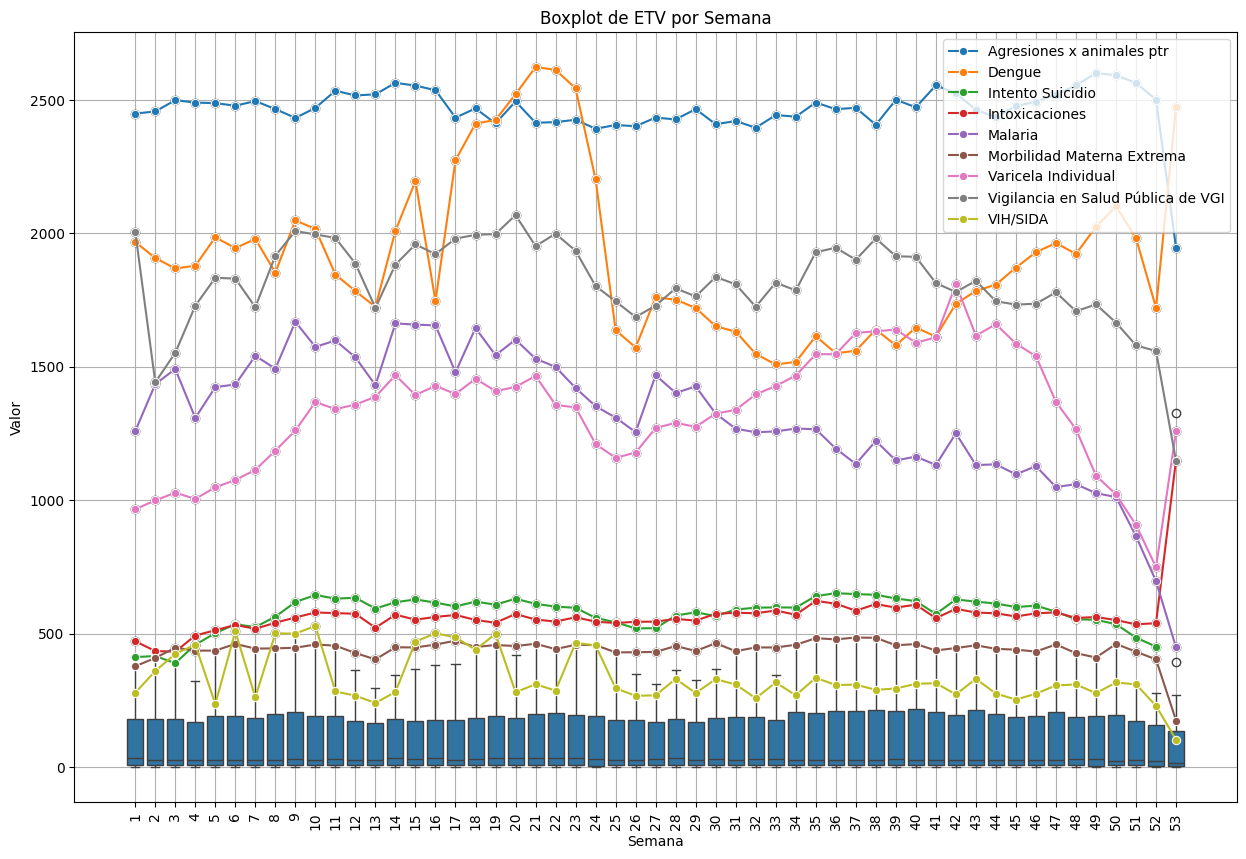

In [30]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='semana', y='Valor', data=df_melted)
#df_promedio['semana'] = df_promedio['semana']+1
sns.lineplot(x='semana', y='AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA', data=df_promedio, label='Agresiones x animales ptr', marker='o')
#sns.lineplot(x='semana', y='CHIKUNGUNYA', data=df_promedio, label='Chikungunya', marker='o')
sns.lineplot(x='semana', y='DENGUE', data=df_promedio, label='Dengue', marker='o')
sns.lineplot(x='semana', y='INTENTO DE SUICIDIO', data=df_promedio, label='Intento Suicidio', marker='o')
sns.lineplot(x='semana', y='INTOXICACIONES', data=df_promedio, label='Intoxicaciones', marker='o')
sns.lineplot(x='semana', y= 'MALARIA', data=df_promedio, label='Malaria', marker='o')
sns.lineplot(x='semana', y= 'MORBILIDAD MATERNA EXTREMA', data=df_promedio, label='Morbilidad Materna Extrema', marker='o')
sns.lineplot(x='semana', y= 'VARICELA INDIVIDUAL', data=df_promedio, label='Varicela Individual', marker='o')
sns.lineplot(x='semana', y=  'VIGILANCIA EN SALUD PÚBLICA DE LA VIOLENCIA DE GÉNERO E INTRAFAMILIAR', data=df_promedio, label='Vigilancia en Salud Pública de VGI', marker='o')
sns.lineplot(x='semana', y=  'VIH/SIDA/MORTALIDAD POR SIDA', data=df_promedio, label='VIH/SIDA', marker='o')
# Configurar el gráfico
plt.xlabel('Semana')
plt.ylabel('Valor')
plt.title('Boxplot de ETV por Semana')
plt.xticks(rotation=90)
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Vigilancia en salud pública ETVs

In [ ]:
ETV, ETV2, ETV3 = 'DENGUE', 'DENGUE GRAVE','MALARIA'

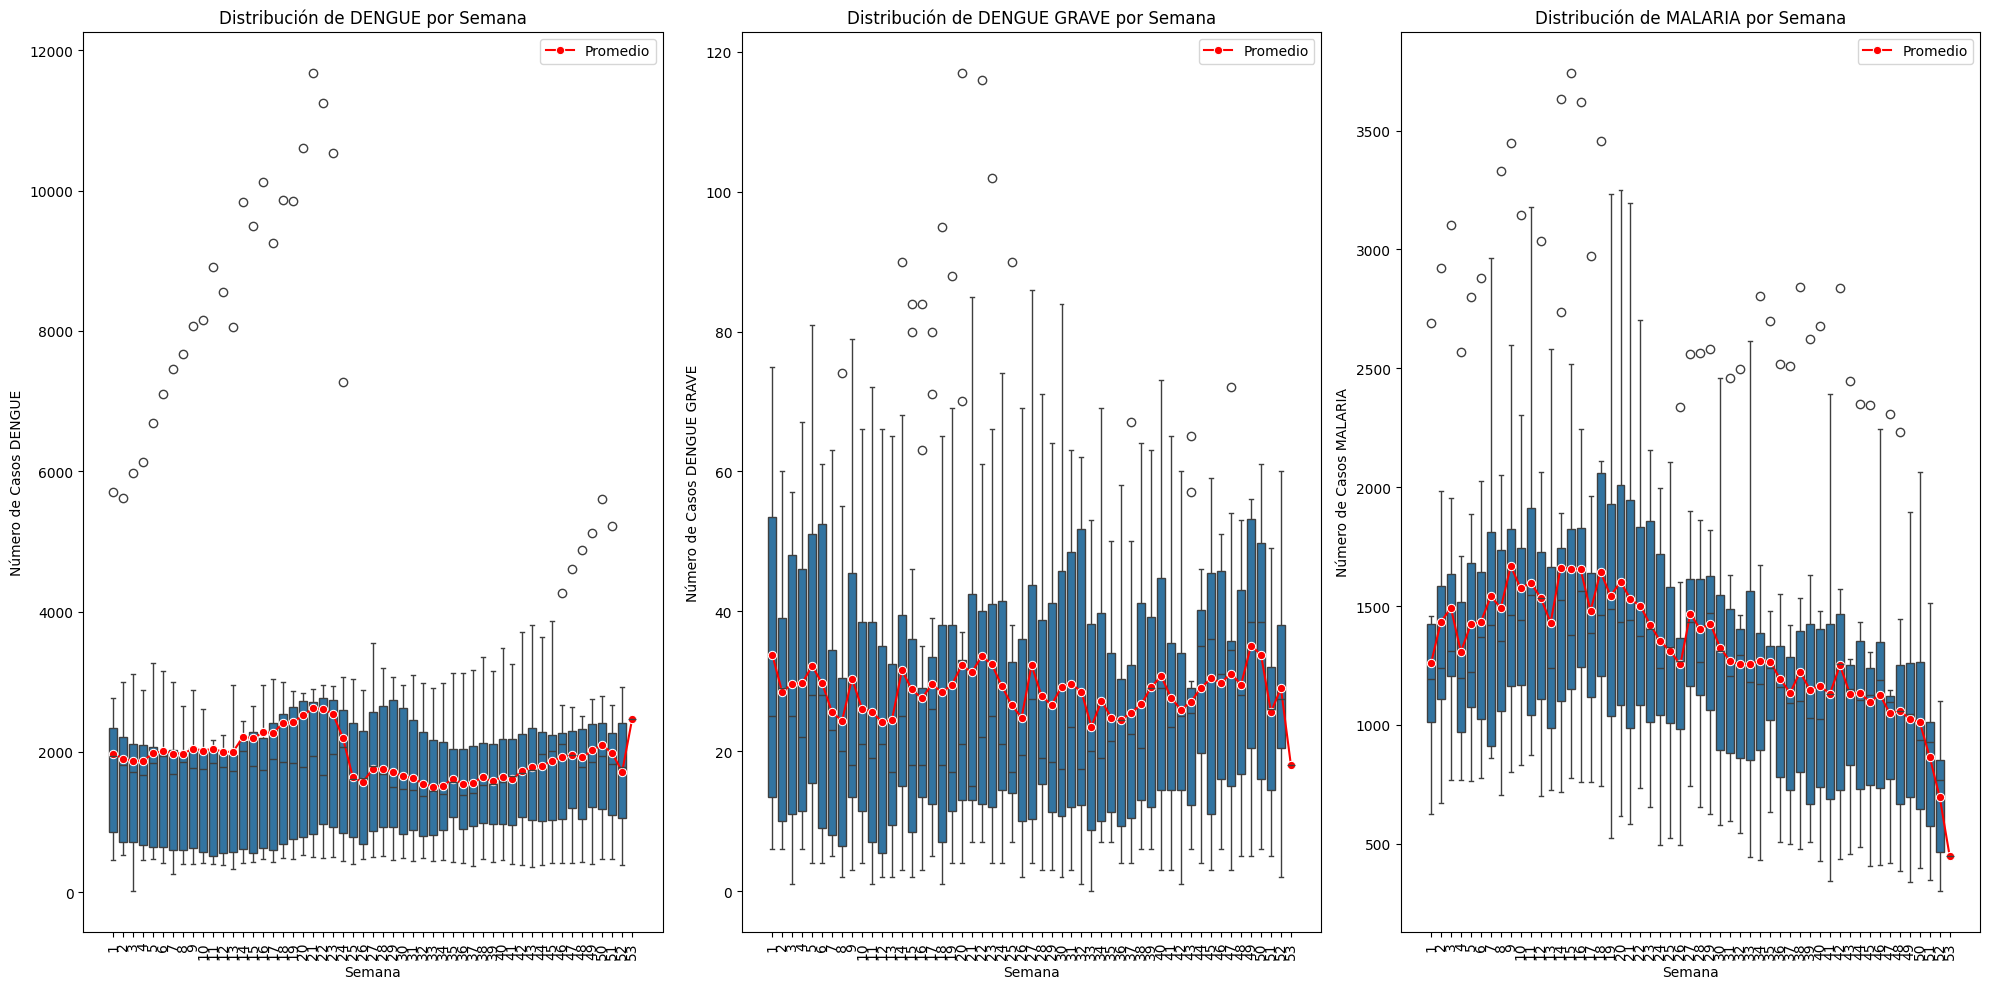

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.boxplot(ax=axes[0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
#axes[0].set(ylim=(0, 7e3))
axes[0].set_title(f'Distribución de {ETV} por Semana')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel(f'Número de Casos {ETV}')
axes[0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[1].set(ylim=(0, 7e3))
axes[1].set_title(f'Distribución de {ETV2} por Semana')
axes[1].set_xlabel('Semana')
axes[1].set_ylabel(f'Número de Casos {ETV2}')
axes[1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[2], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[2], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[2].set_title(f'Distribución de {ETV3} por Semana')
axes[2].set_xlabel('Semana')
axes[2].set_ylabel(f'Número de Casos {ETV3}')
axes[2].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Fuera de escala

In [ ]:
ETV, ETV2, ETV3 = 'CHIKUNGUNYA', 'INFECCION RESPIRATORIA AGUDA GRAVE IRAG INUSITADA', 'ZIKA'

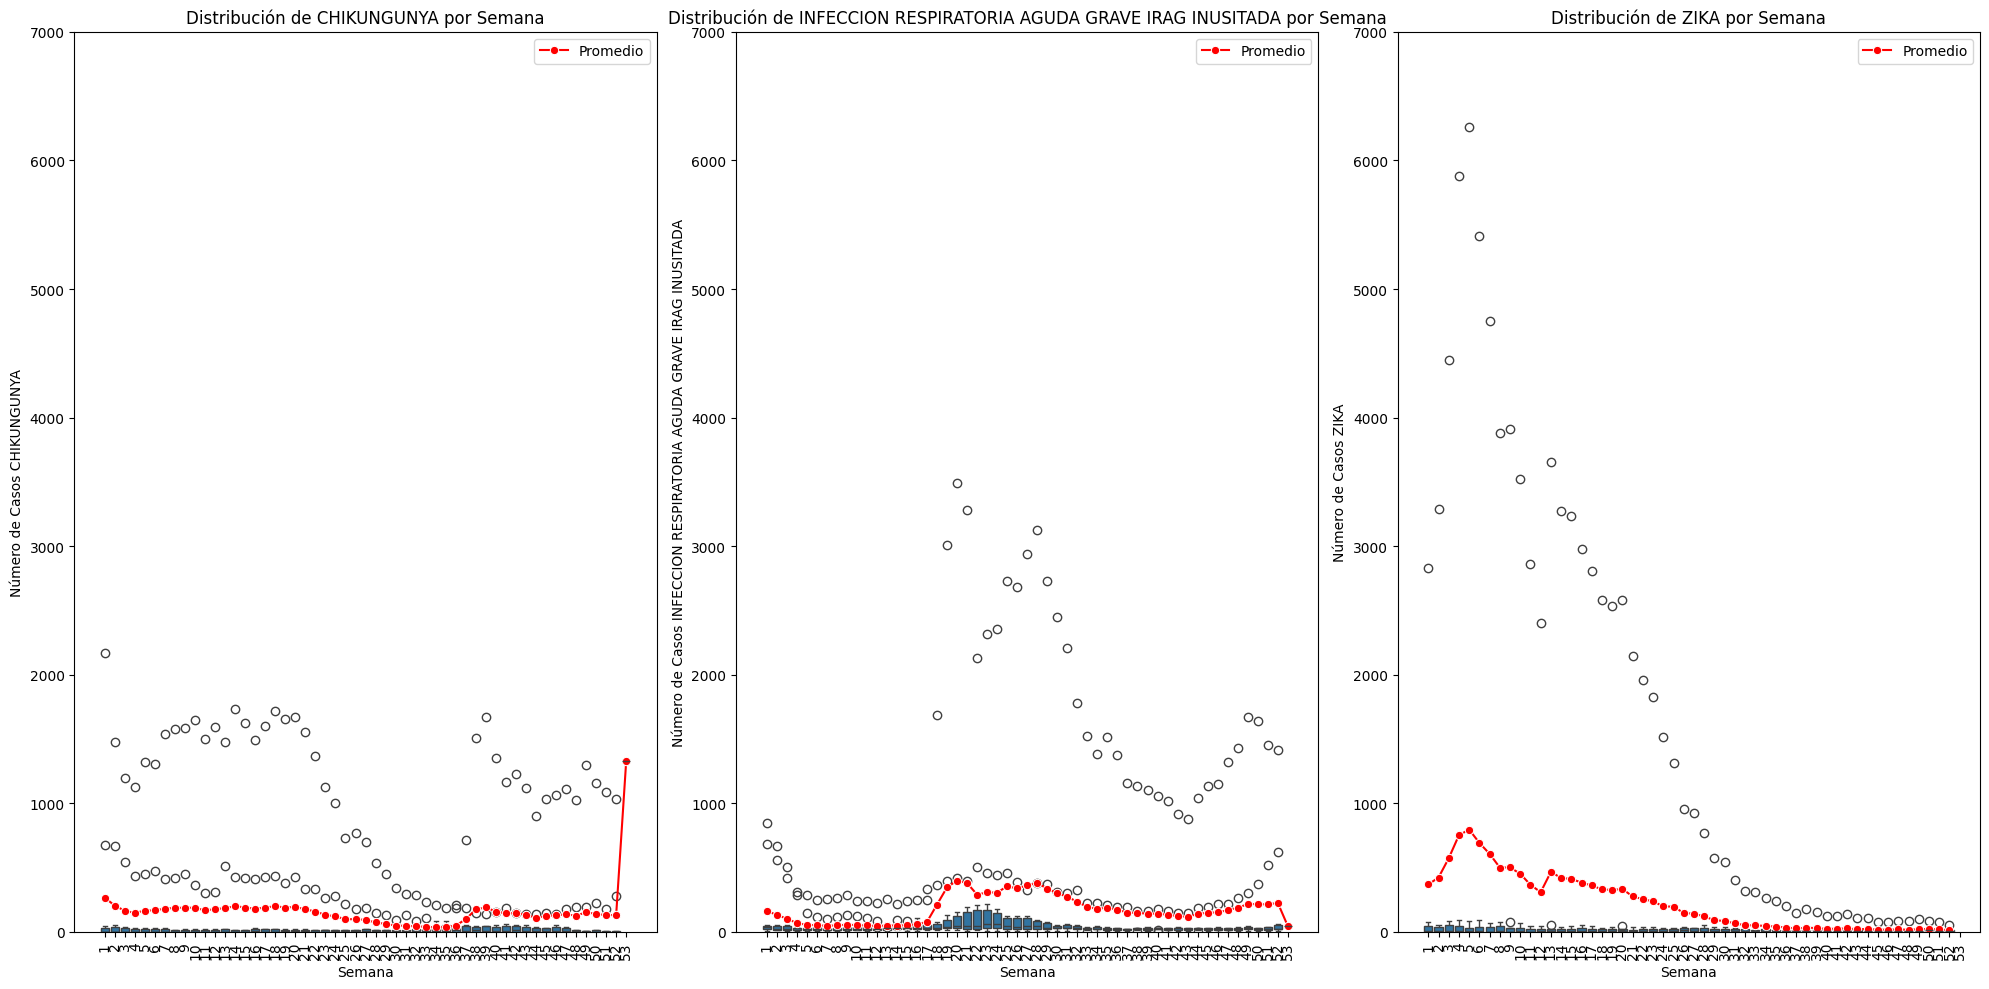

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.boxplot(ax=axes[0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0].set(ylim=(0, 7e3))
axes[0].set_title(f'Distribución de {ETV} por Semana')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel(f'Número de Casos {ETV}')
axes[0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1].set(ylim=(0, 7e3))
axes[1].set_title(f'Distribución de {ETV2} por Semana')
axes[1].set_xlabel('Semana')
axes[1].set_ylabel(f'Número de Casos {ETV2}')
axes[1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[2], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[2], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[2].set(ylim=(0, 7e3))
axes[2].set_title(f'Distribución de {ETV3} por Semana')
axes[2].set_xlabel('Semana')
axes[2].set_ylabel(f'Número de Casos {ETV3}')
axes[2].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Atípicos por lo alto

In [ ]:
ETV, ETV2, ETV3, ETV4 = 'LEPTOSPIROSIS', 'SARAMPION + RUBEOLA', 'VIH/SIDA/MORTALIDAD POR SIDA', 'LESIONES DE CAUSA EXTERNA'

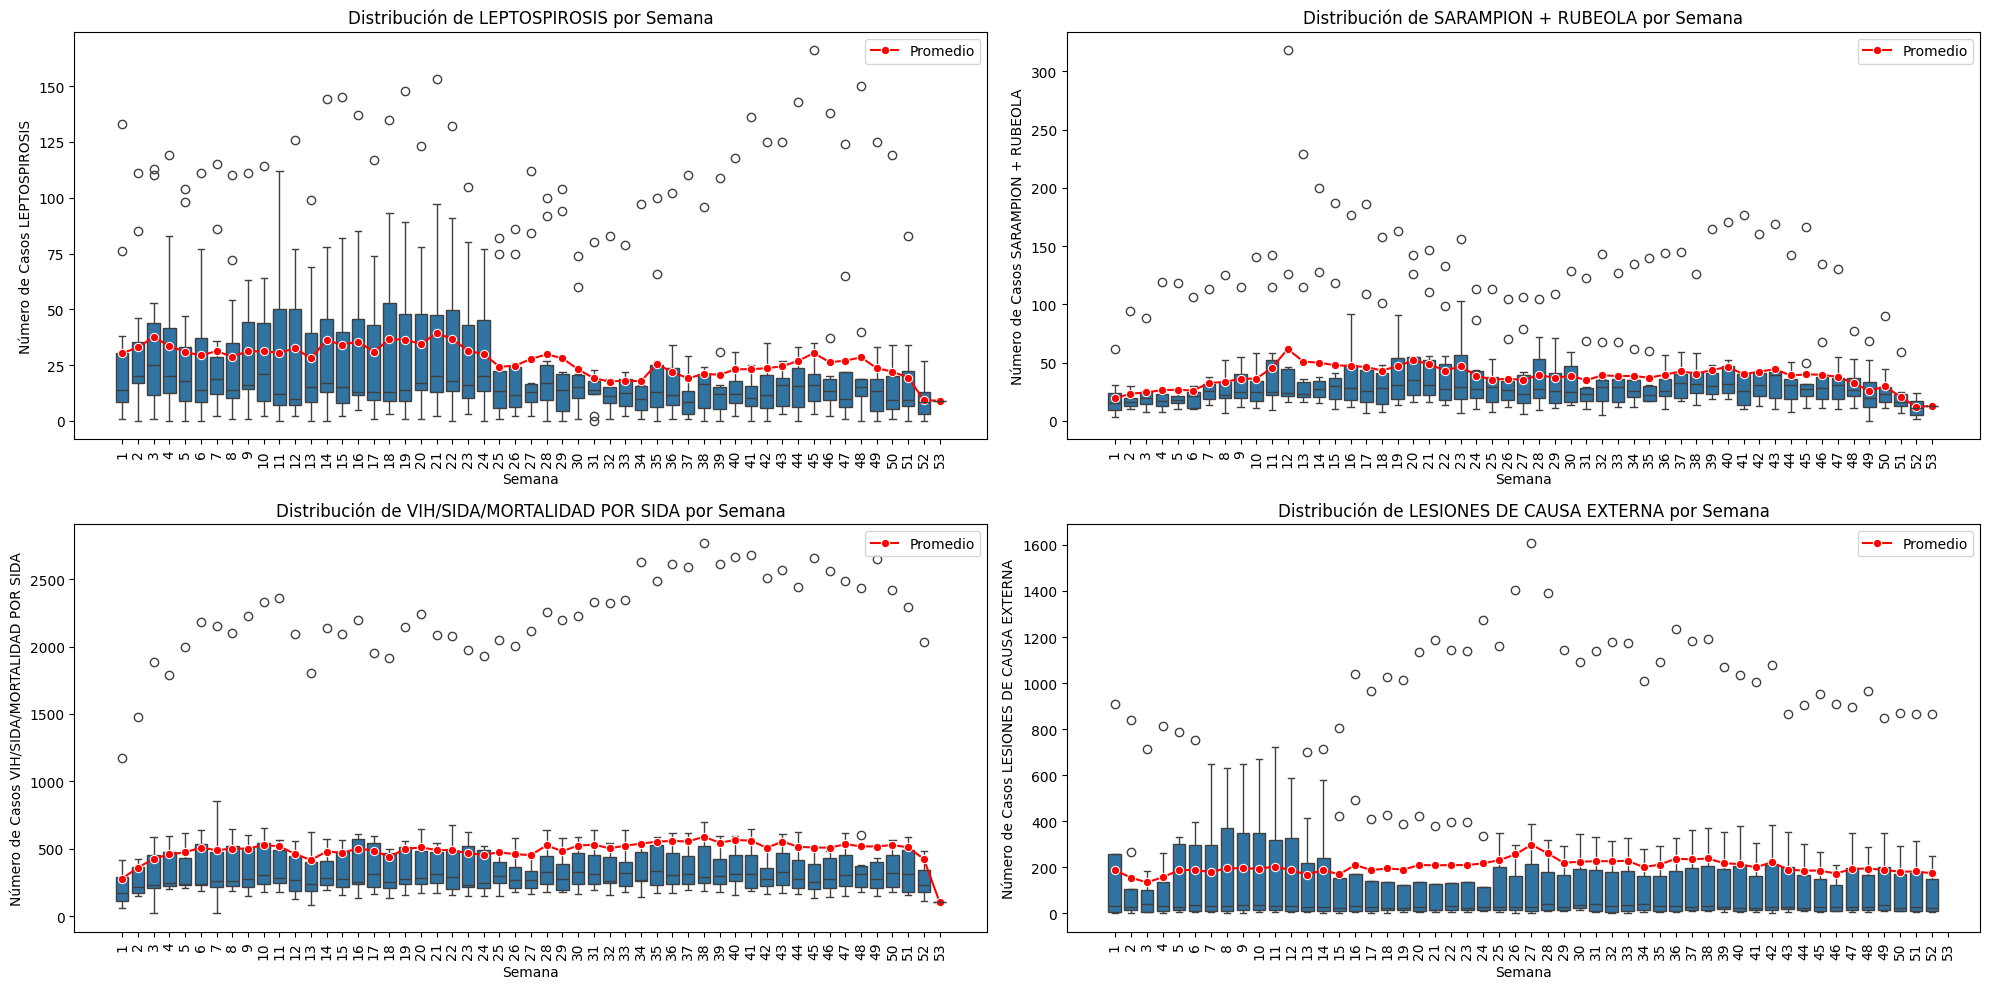

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
#axes[0,1].set(ylim=(0, 7e3))
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[1].set(ylim=(0, 7e3))
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Atípicos por lo bajo

In [ ]:
ETV, ETV2, ETV3 = 'BAJO PESO AL NACER', 'DEFECTOS CONGENITOS', 'MORTALIDAD PERINATAL Y NEONATAL TARDÍA'

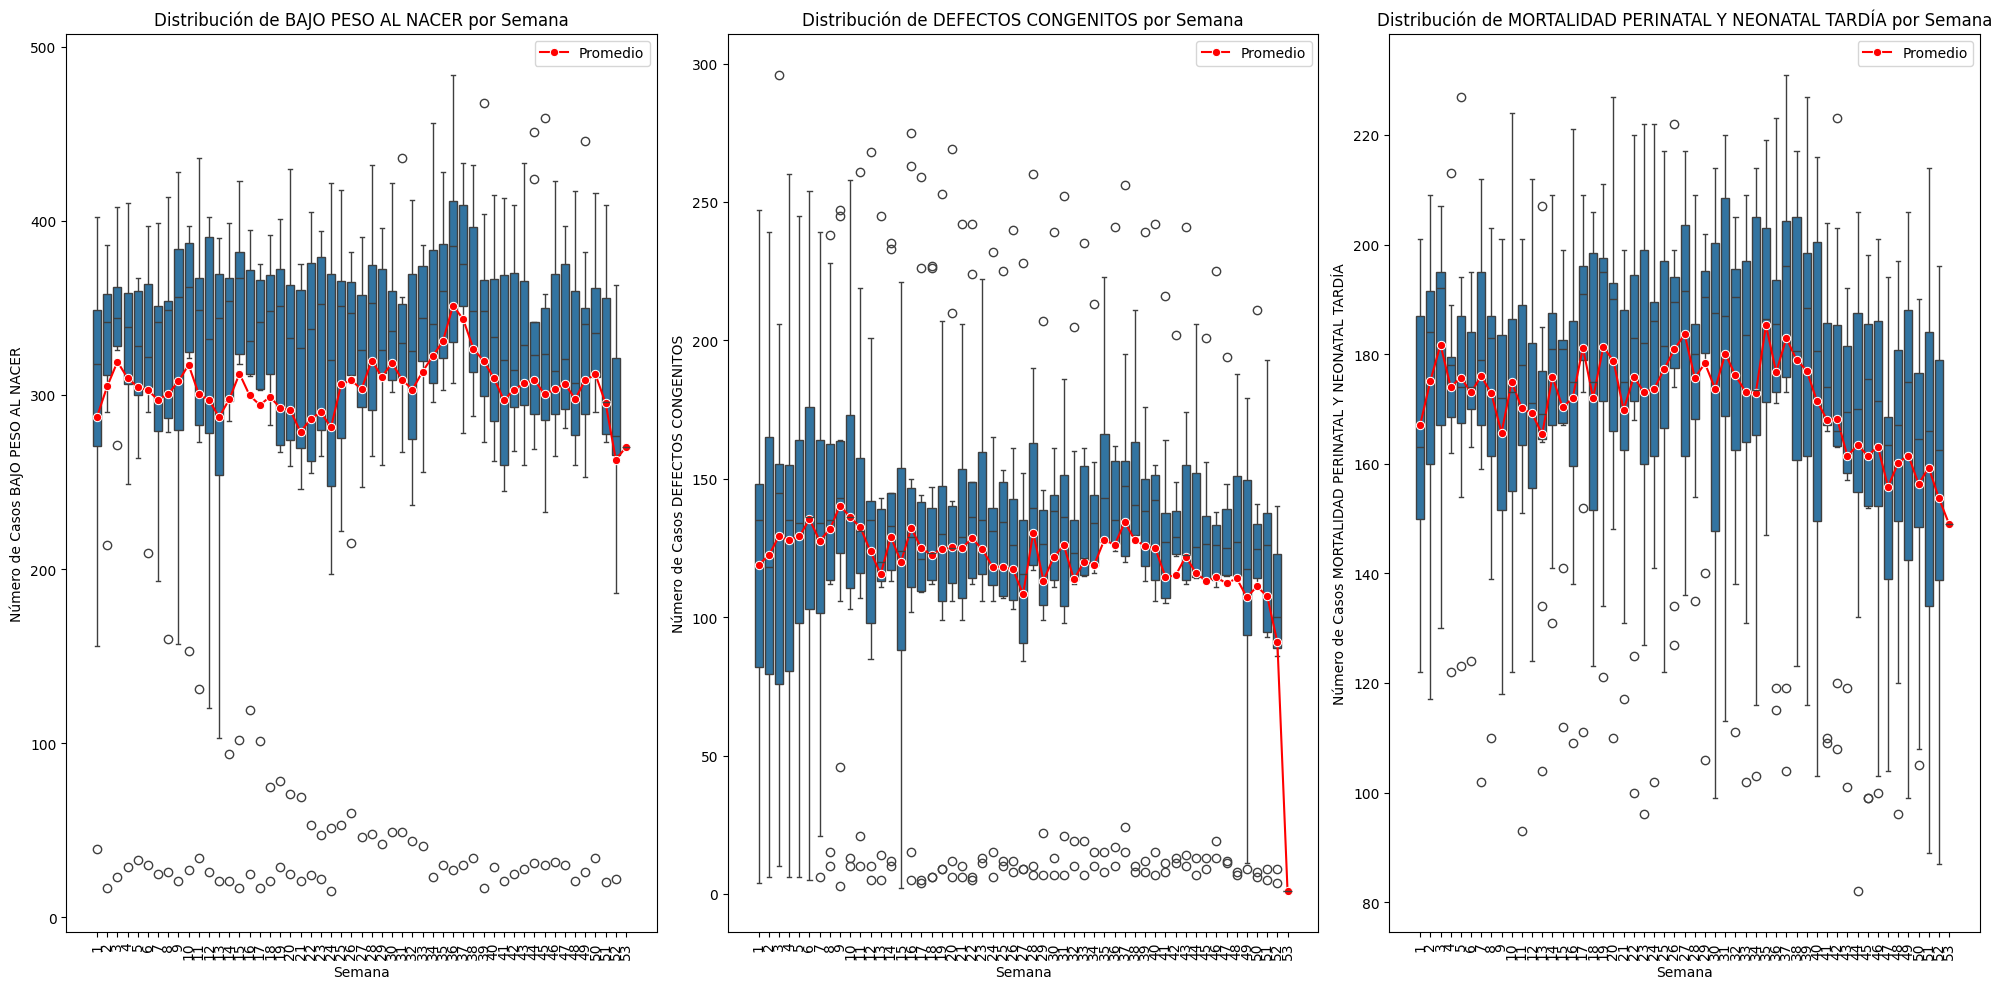

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.boxplot(ax=axes[0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
#axes[0].set(ylim=(0, 7e3))
axes[0].set_title(f'Distribución de {ETV} por Semana')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel(f'Número de Casos {ETV}')
axes[0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[1].set(ylim=(0, 7e3))
axes[1].set_title(f'Distribución de {ETV2} por Semana')
axes[1].set_xlabel('Semana')
axes[1].set_ylabel(f'Número de Casos {ETV2}')
axes[1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[2], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[2], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[2].set_title(f'Distribución de {ETV3} por Semana')
axes[2].set_xlabel('Semana')
axes[2].set_ylabel(f'Número de Casos {ETV3}')
axes[2].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Escala continua

In [ ]:
ETV, ETV2, ETV3, ETV4, ETV5 = 'FIEBRE AMARILLA','LEISHMANIASIS VISCERAL', 'LEPRA', 'TETANOS ACCIDENTAL', 'TETANOS NEONATAL'

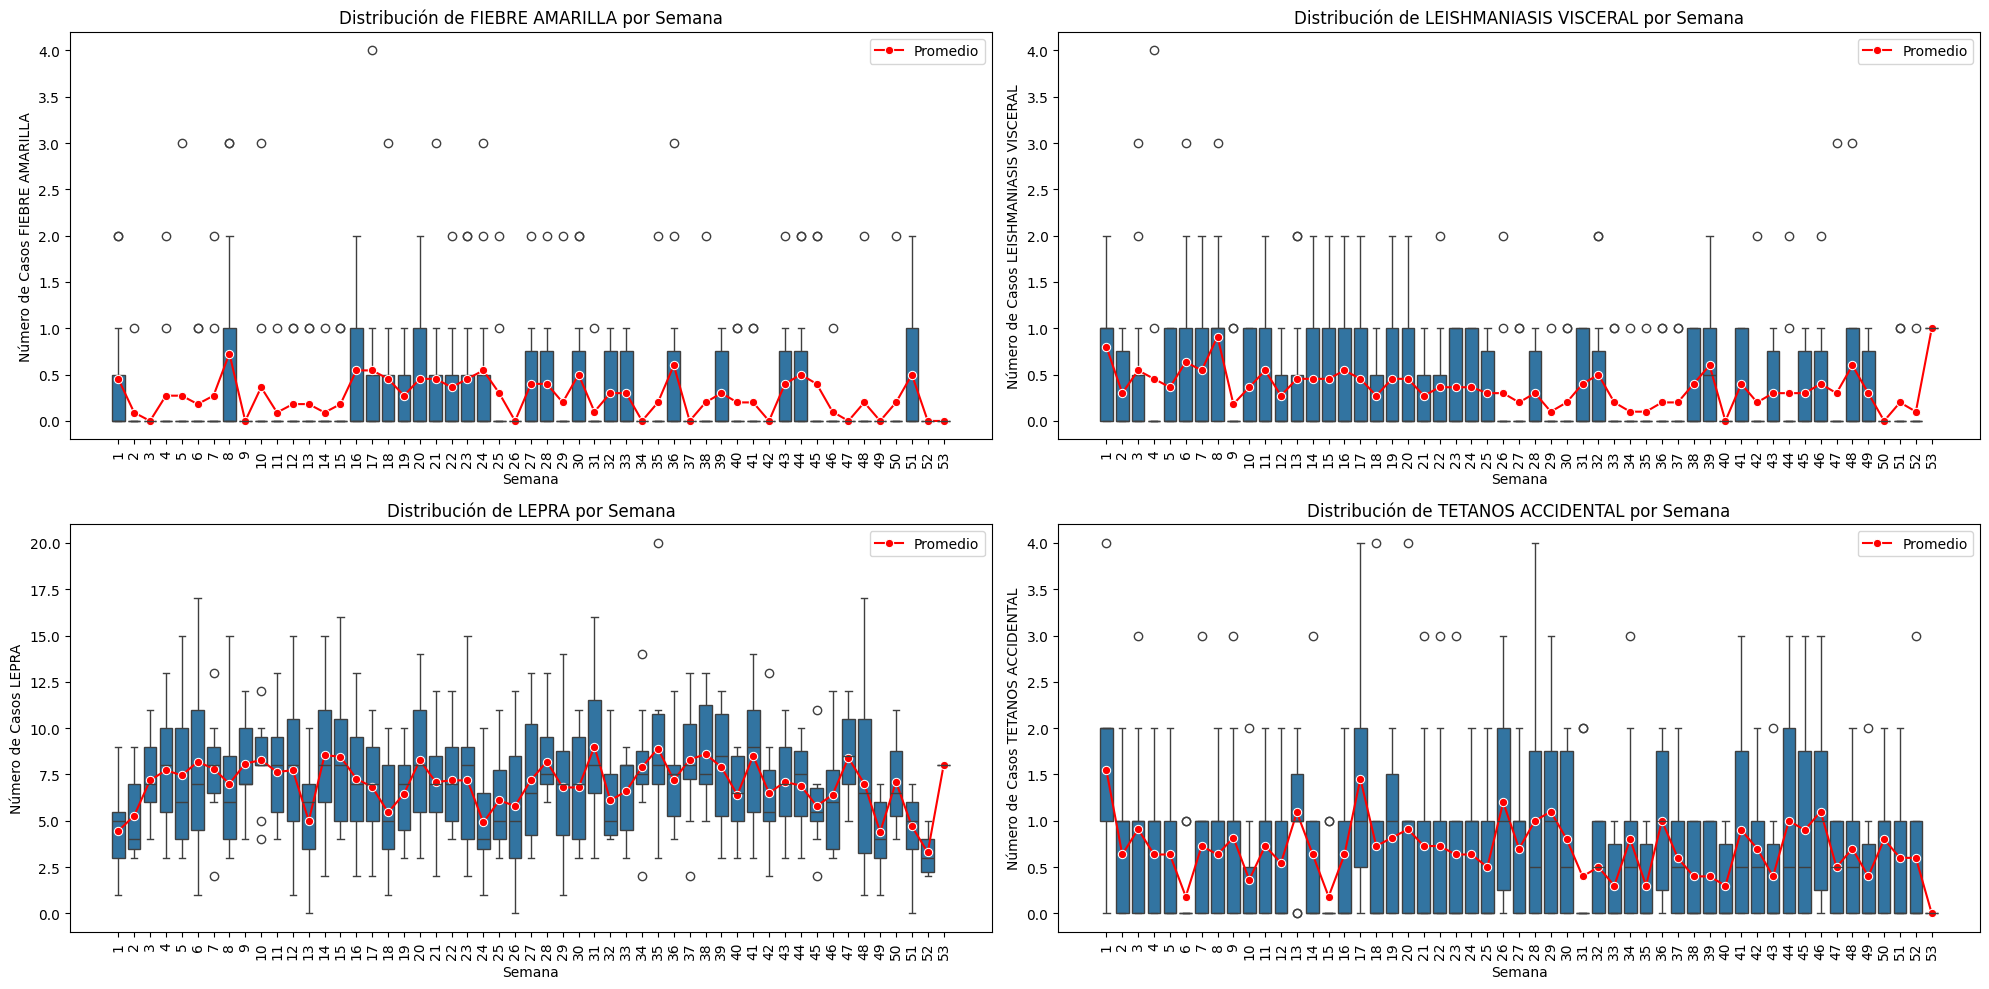

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
#axes[0,1].set(ylim=(0, 7e3))
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[1].set(ylim=(0, 7e3))
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Proporciones

In [ ]:
ETV, ETV2, ETV3 = 'TETANOS NEONATAL', 'TIFUS ENDEMICO TRASMITIDO POR PULGAS', 'TIFUS EPIDEMICO TRANSMITIDO POR PIOJOS'

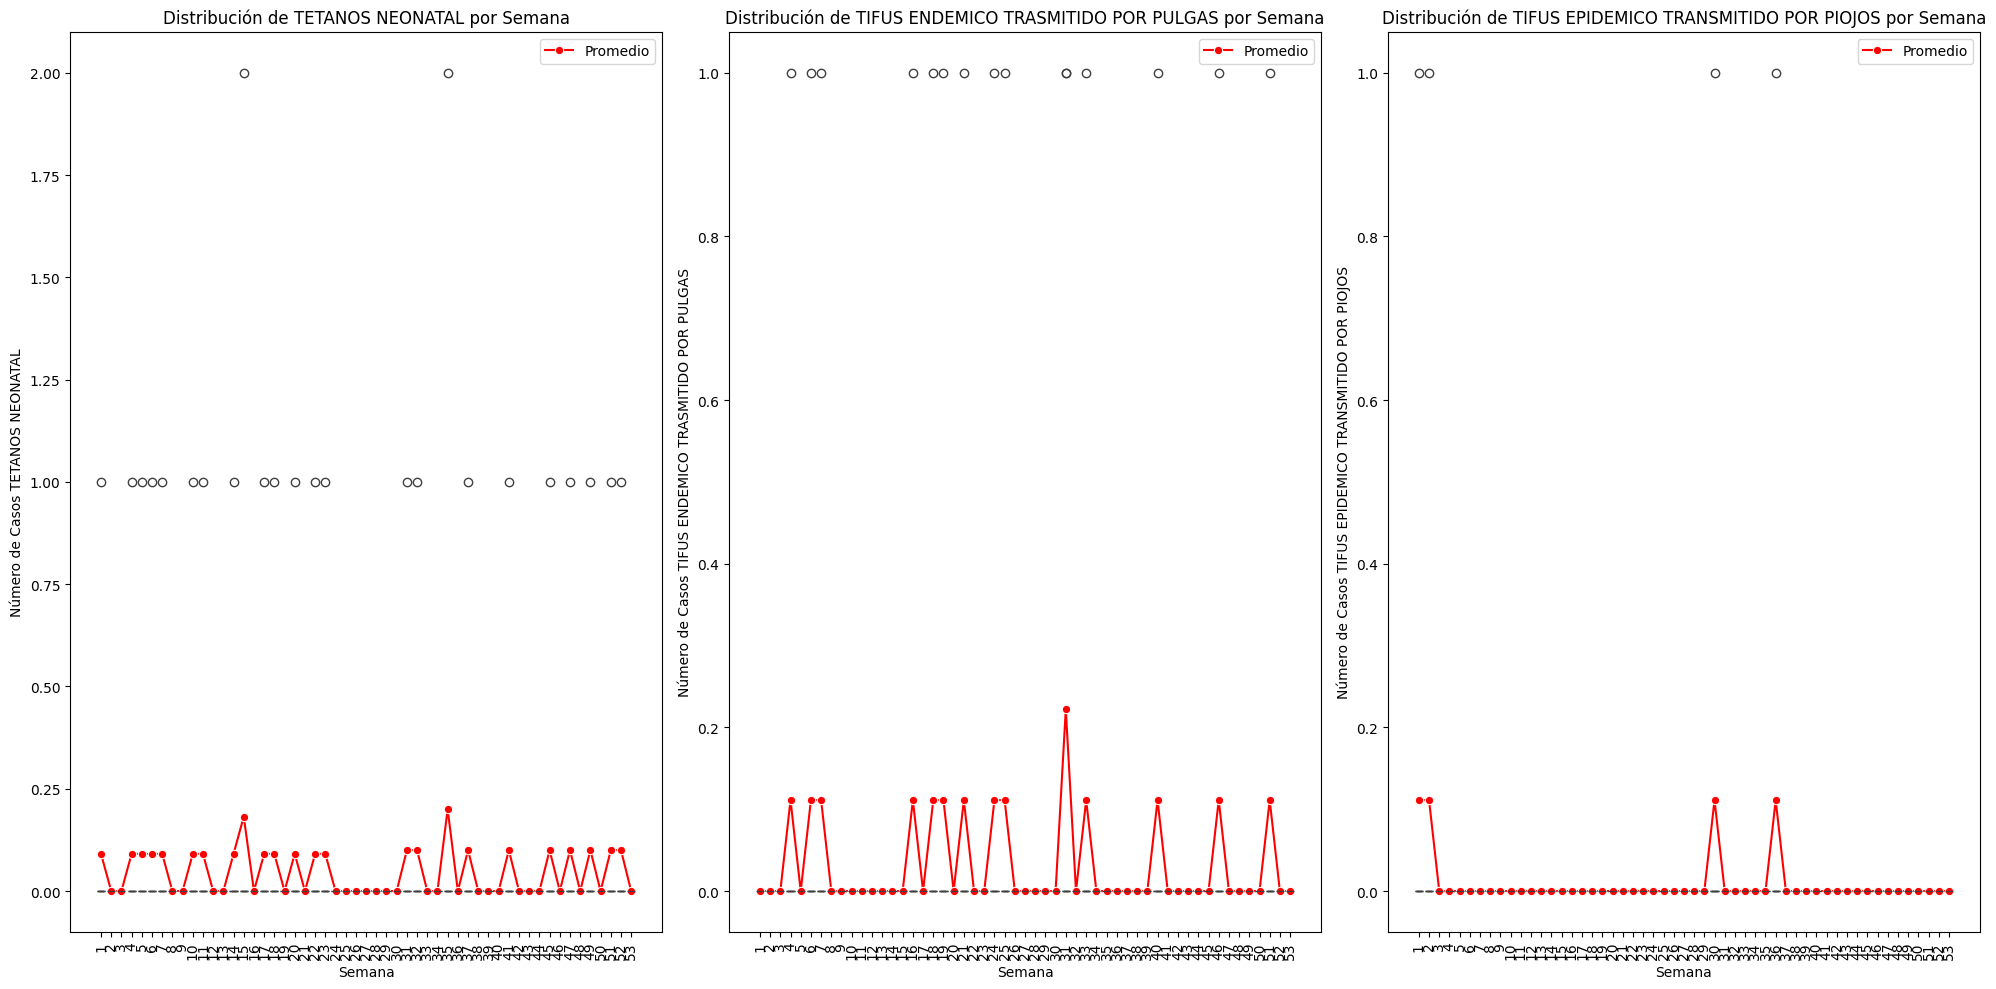

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.boxplot(ax=axes[0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
#axes[0].set(ylim=(0, 7e3))
axes[0].set_title(f'Distribución de {ETV} por Semana')
axes[0].set_xlabel('Semana')
axes[0].set_ylabel(f'Número de Casos {ETV}')
axes[0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[1].set(ylim=(0, 7e3))
axes[1].set_title(f'Distribución de {ETV2} por Semana')
axes[1].set_xlabel('Semana')
axes[1].set_ylabel(f'Número de Casos {ETV2}')
axes[1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[2], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[2], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
#axes[2].set(ylim=(0, 7e3))
axes[2].set_title(f'Distribución de {ETV3} por Semana')
axes[2].set_xlabel('Semana')
axes[2].set_ylabel(f'Número de Casos {ETV3}')
axes[2].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Gráficos Boxplot de cada evento

## 'ACCIDENTE OFIDICO' - 'AGRESIONES POR ANIMALES POTENCIALMENTE TRANSMISORES DE RABIA' - 'BAJO PESO AL NACER' - 'CÁNCER DE LA MAMA Y CUELLO UTERINO'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[5:9]
#ETV, ETV2, ETV3, ETV4 = 'ACCIDENTE OFIDICO', 'DENGUE', 'MALARIA', 'ZIKA'

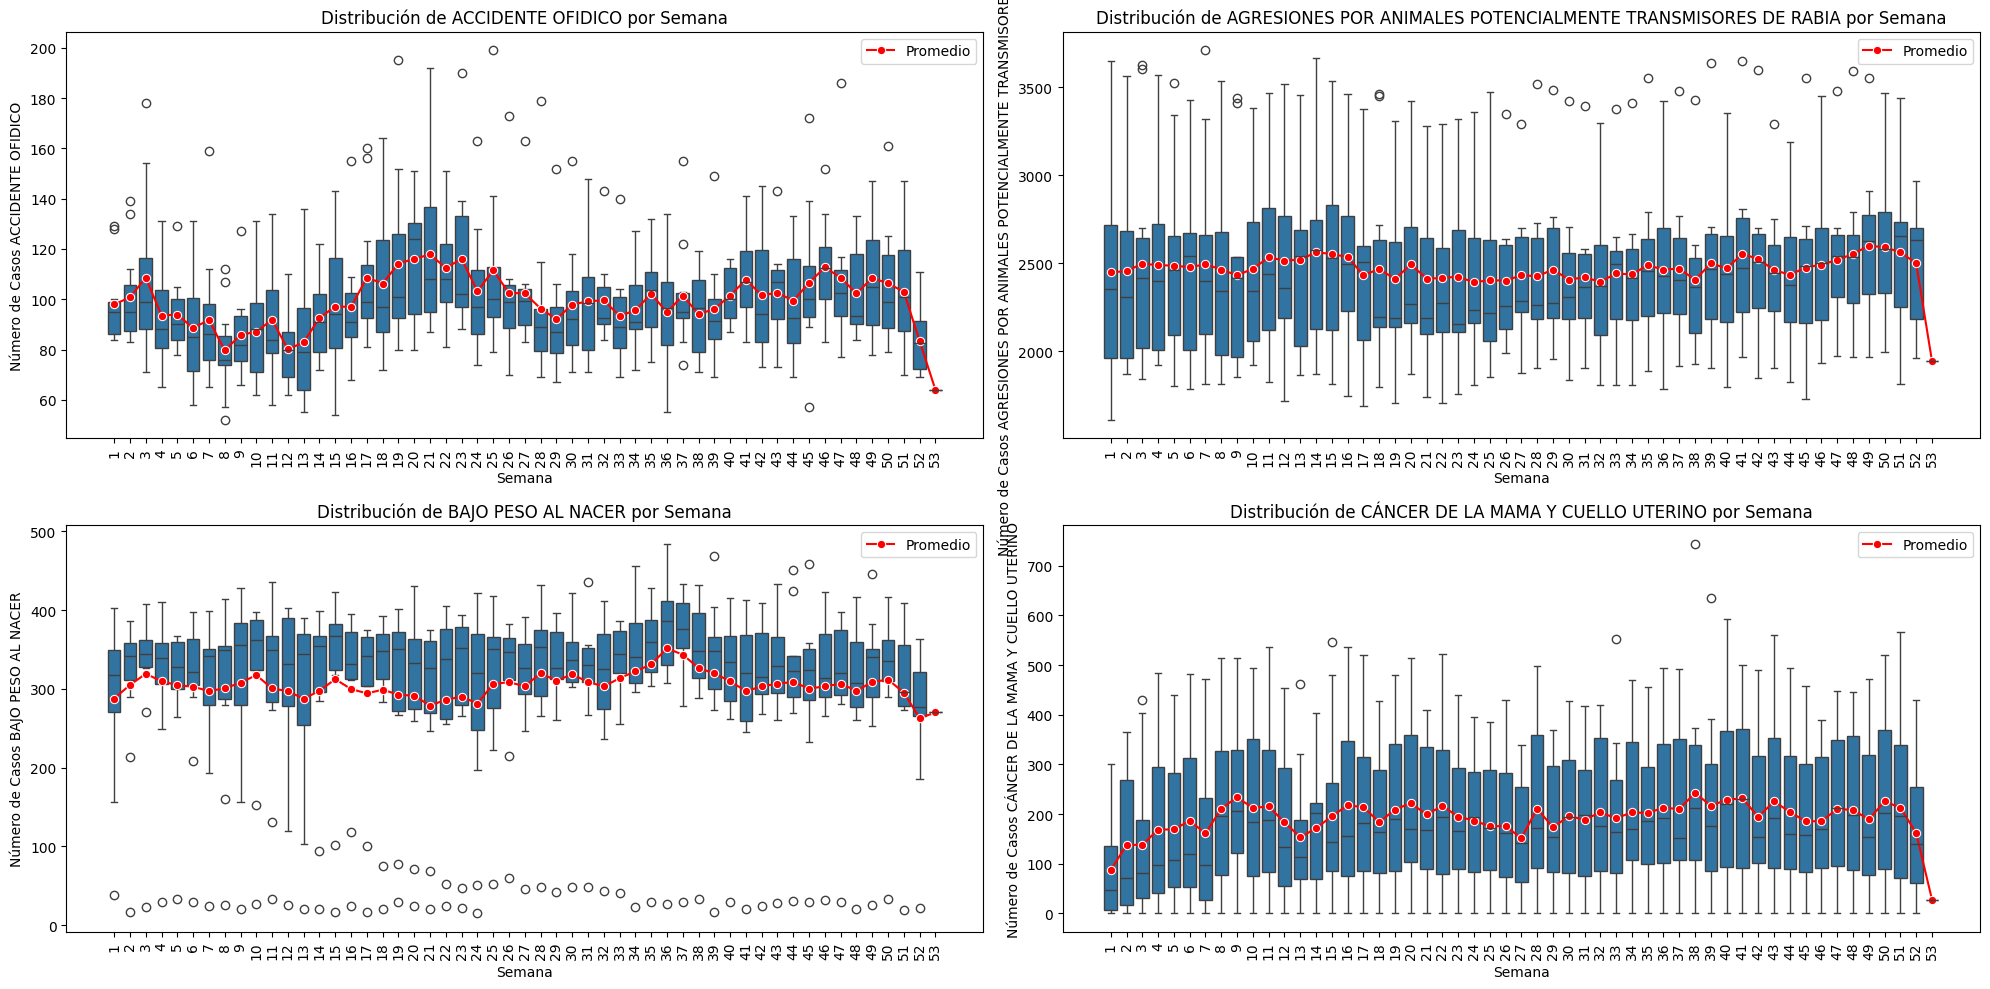

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'CÁNCER EN MENORES DE 18 AÑOS' - 'CHAGAS' - 'CHIKUNGUNYA' - 'DEFECTOS CONGENITOS'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[9:13]

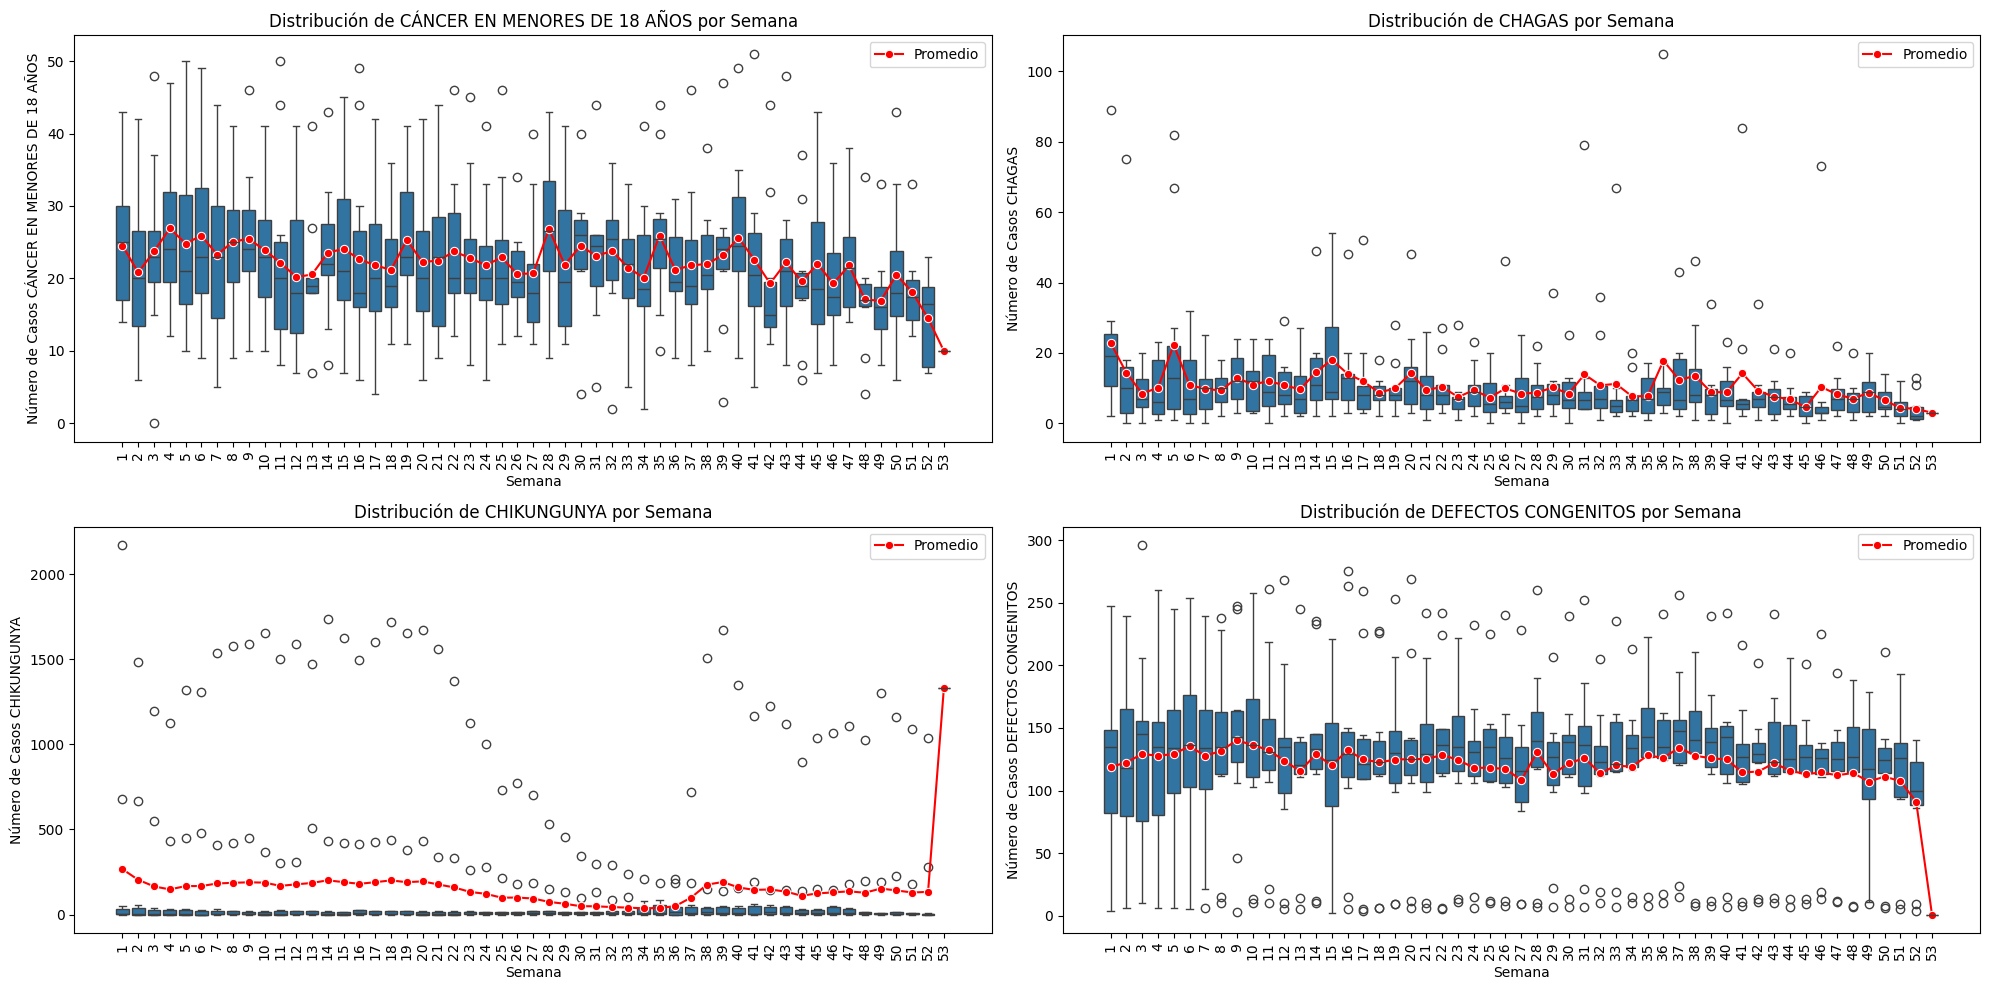

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'DENGUE' - 'DENGUE GRAVE' - 'DESNUTRICIÓN AGUDA EN MENORES DE 5 AÑOS' - 'ENFERMEDAD DIARREICA AGUDA POR ROTAVIRUS'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[13:17]

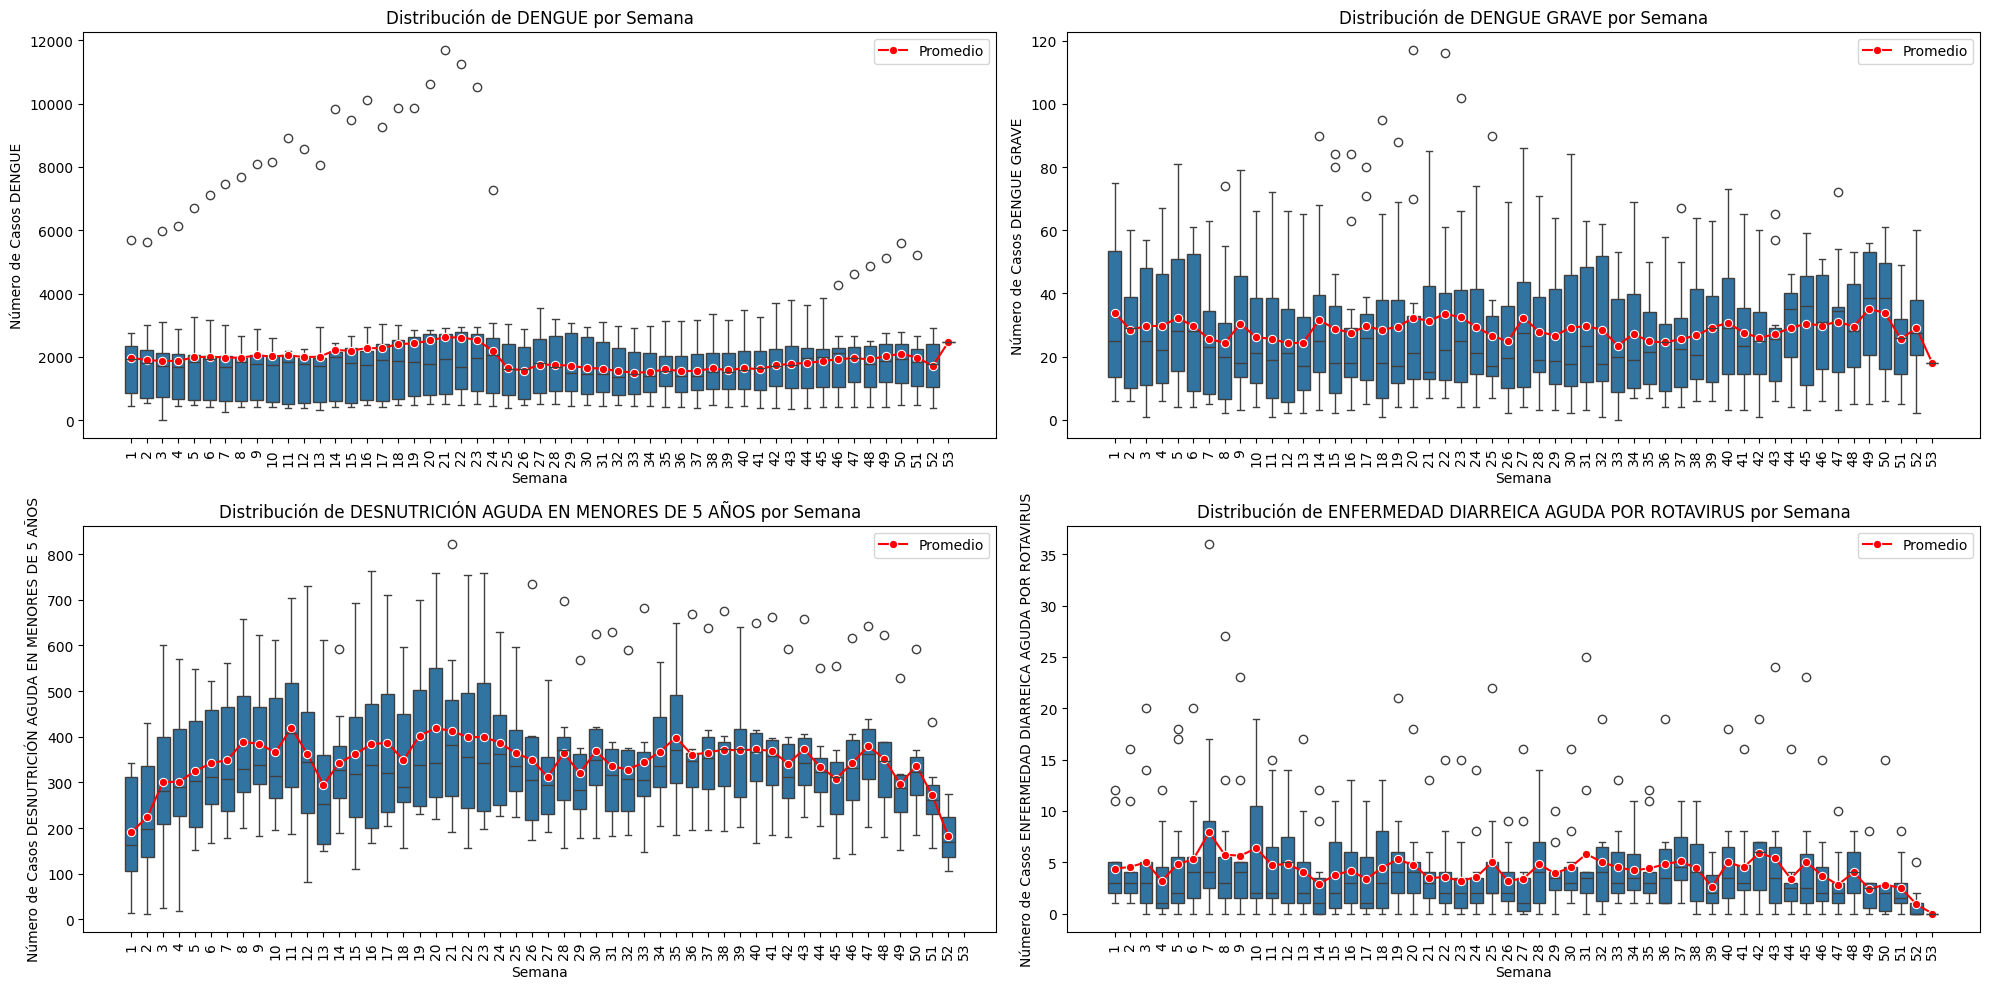

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'ENFERMEDADES HUERFANAS - RARAS' - 'ESI - IRAG (VIGILANCIA CENTINELA)' - 'EVENTO ADVERSO GRAVE POSTERIOR A LA VACUNACIÒN' -  'EXPOSICIÓN A FLÚOR'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[17:21]

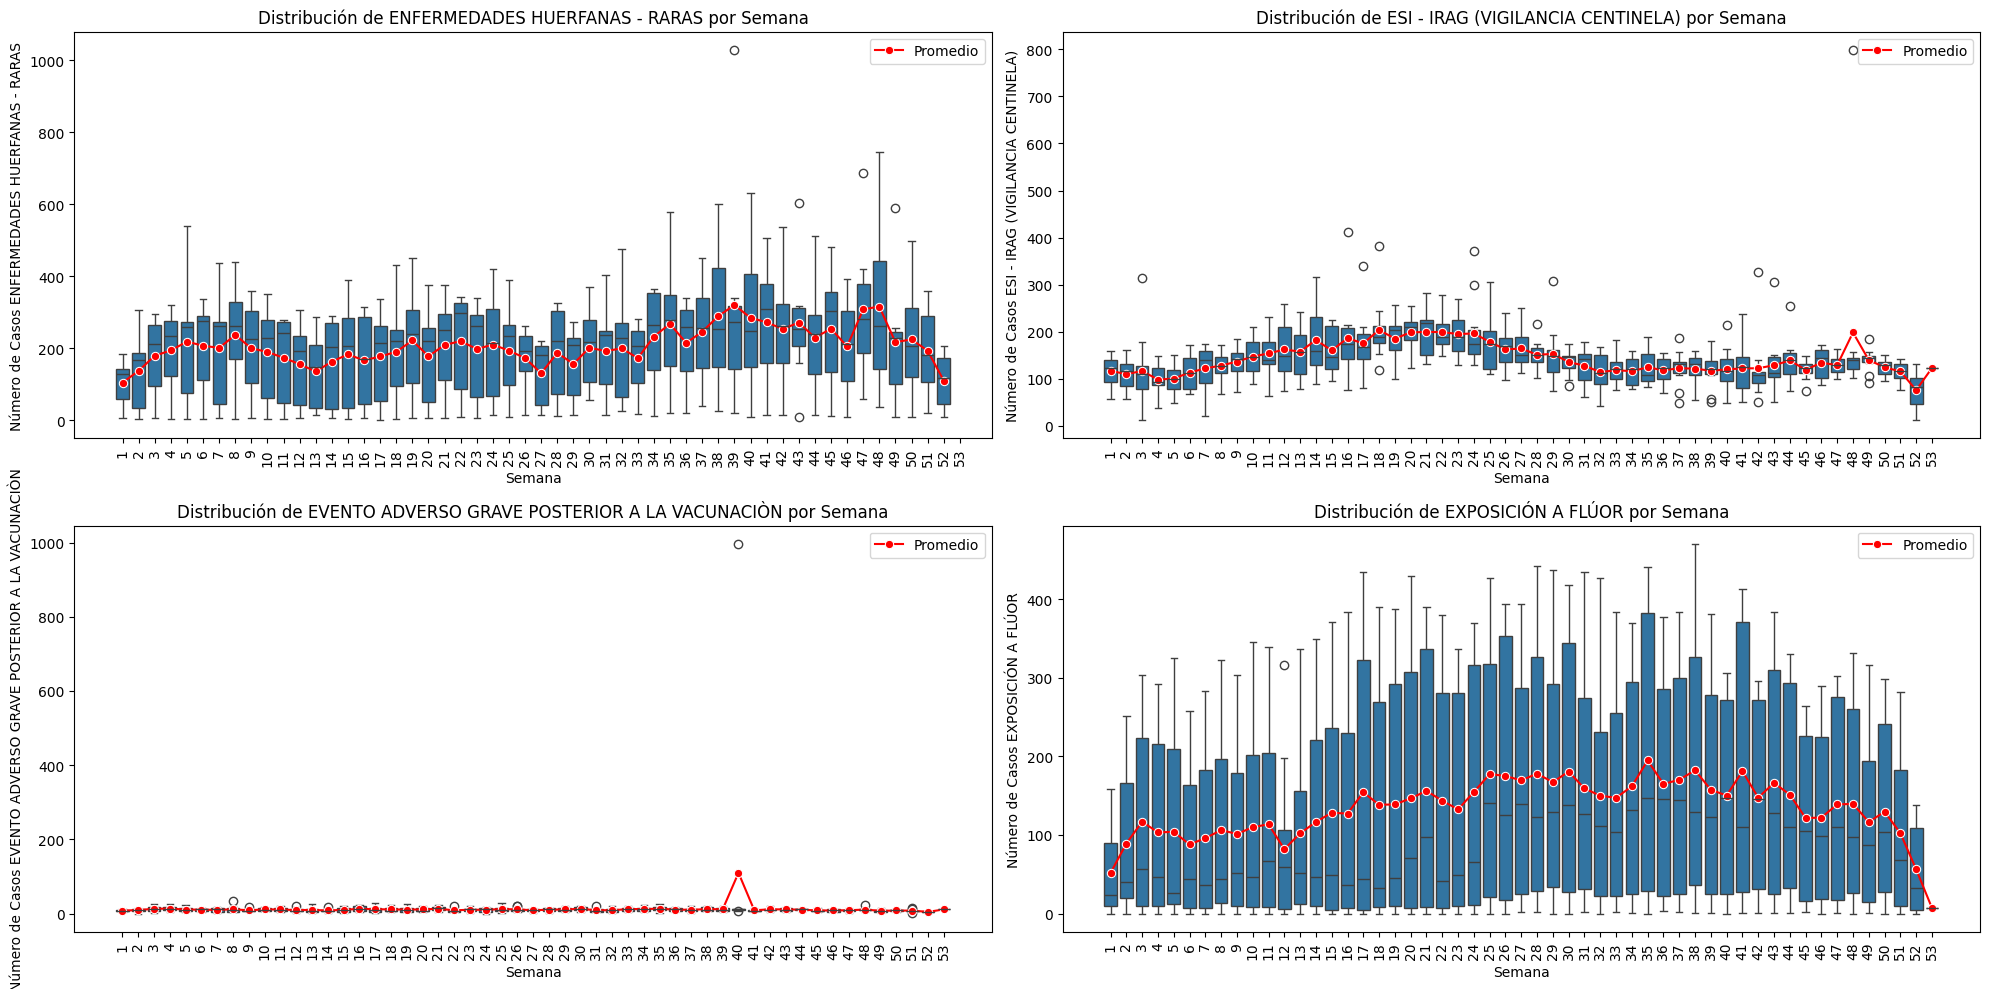

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'FIEBRE AMARILLA' - 'FIEBRE TIFOIDEA Y PARATIFOIDEA' - 'HEPATITIS B, C Y COINFECCIÓN HEPATITIS B Y DELTA'- 'INFECCION RESPIRATORIA AGUDA GRAVE IRAG INUSITADA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[21:25]

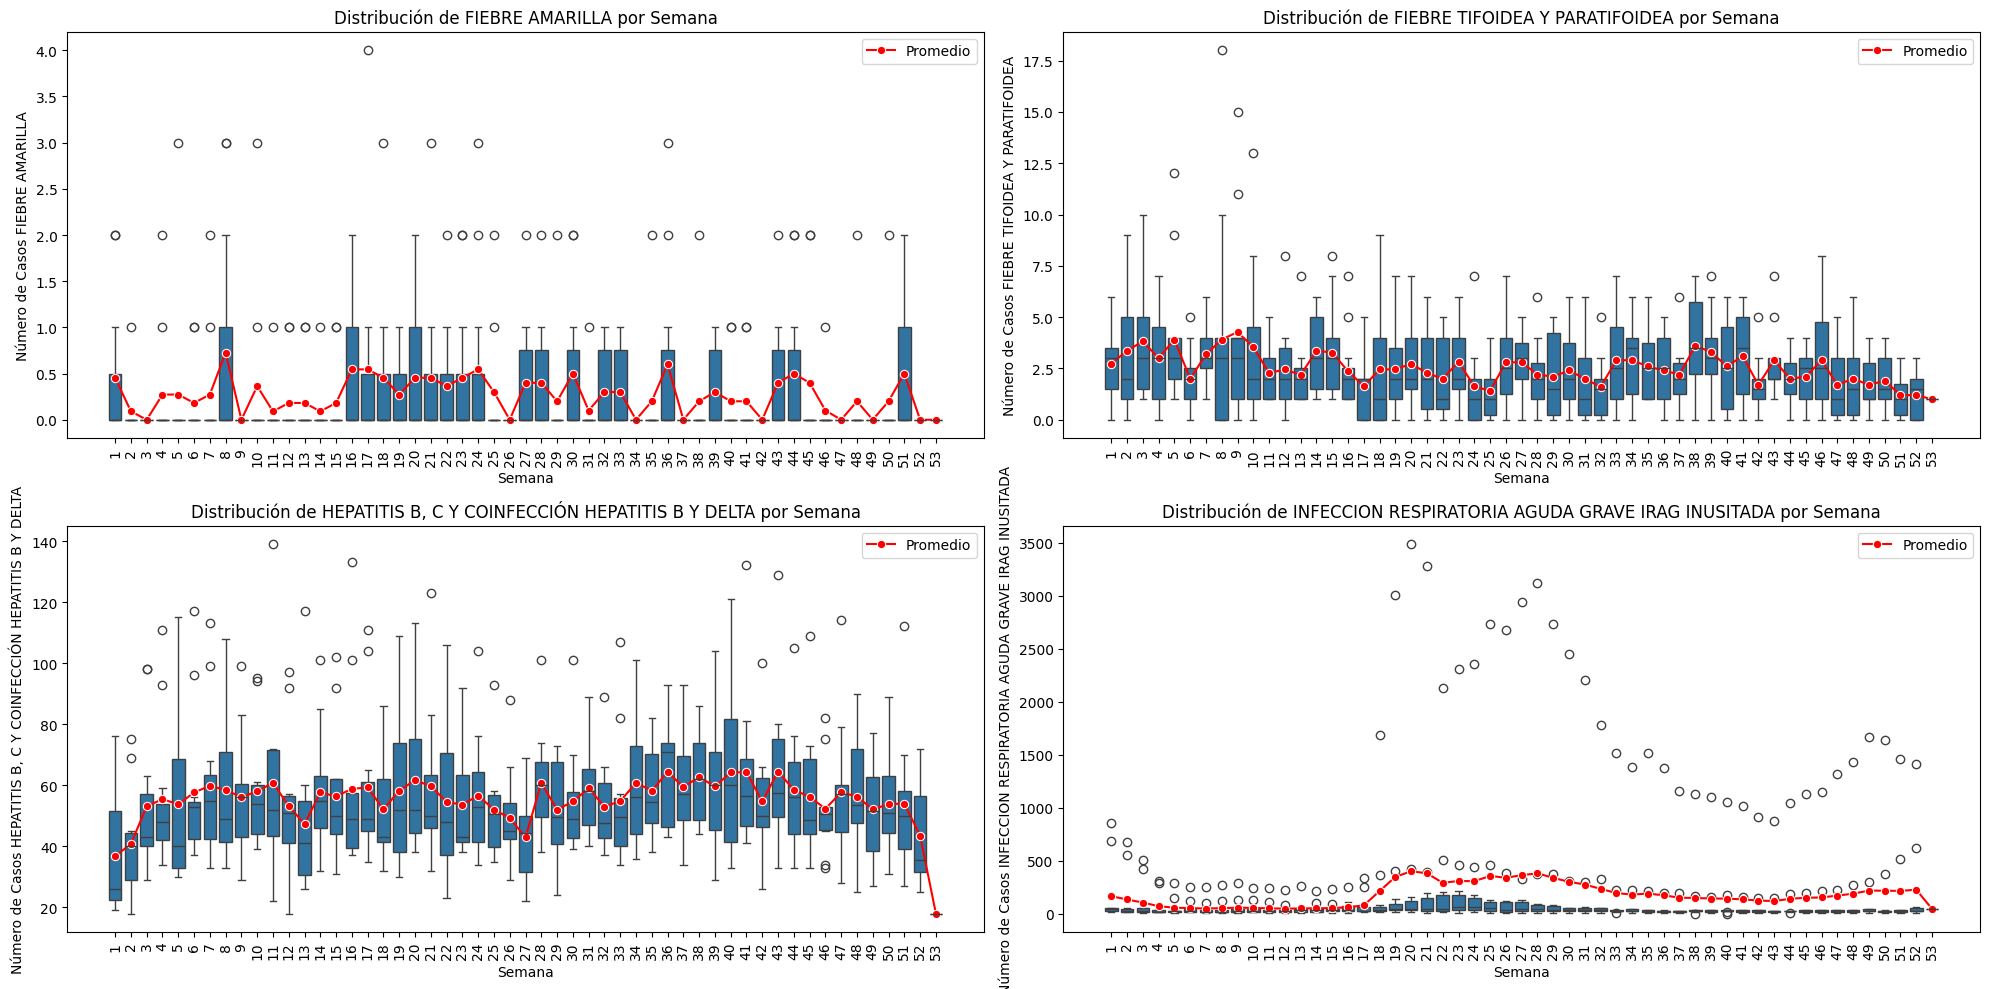

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'INTENTO DE SUICIDIO' - 'INTOXICACIONES' - 'LEISHMANIASIS CUTANEA' - 'LEISHMANIASIS MUCOSA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[25:29]

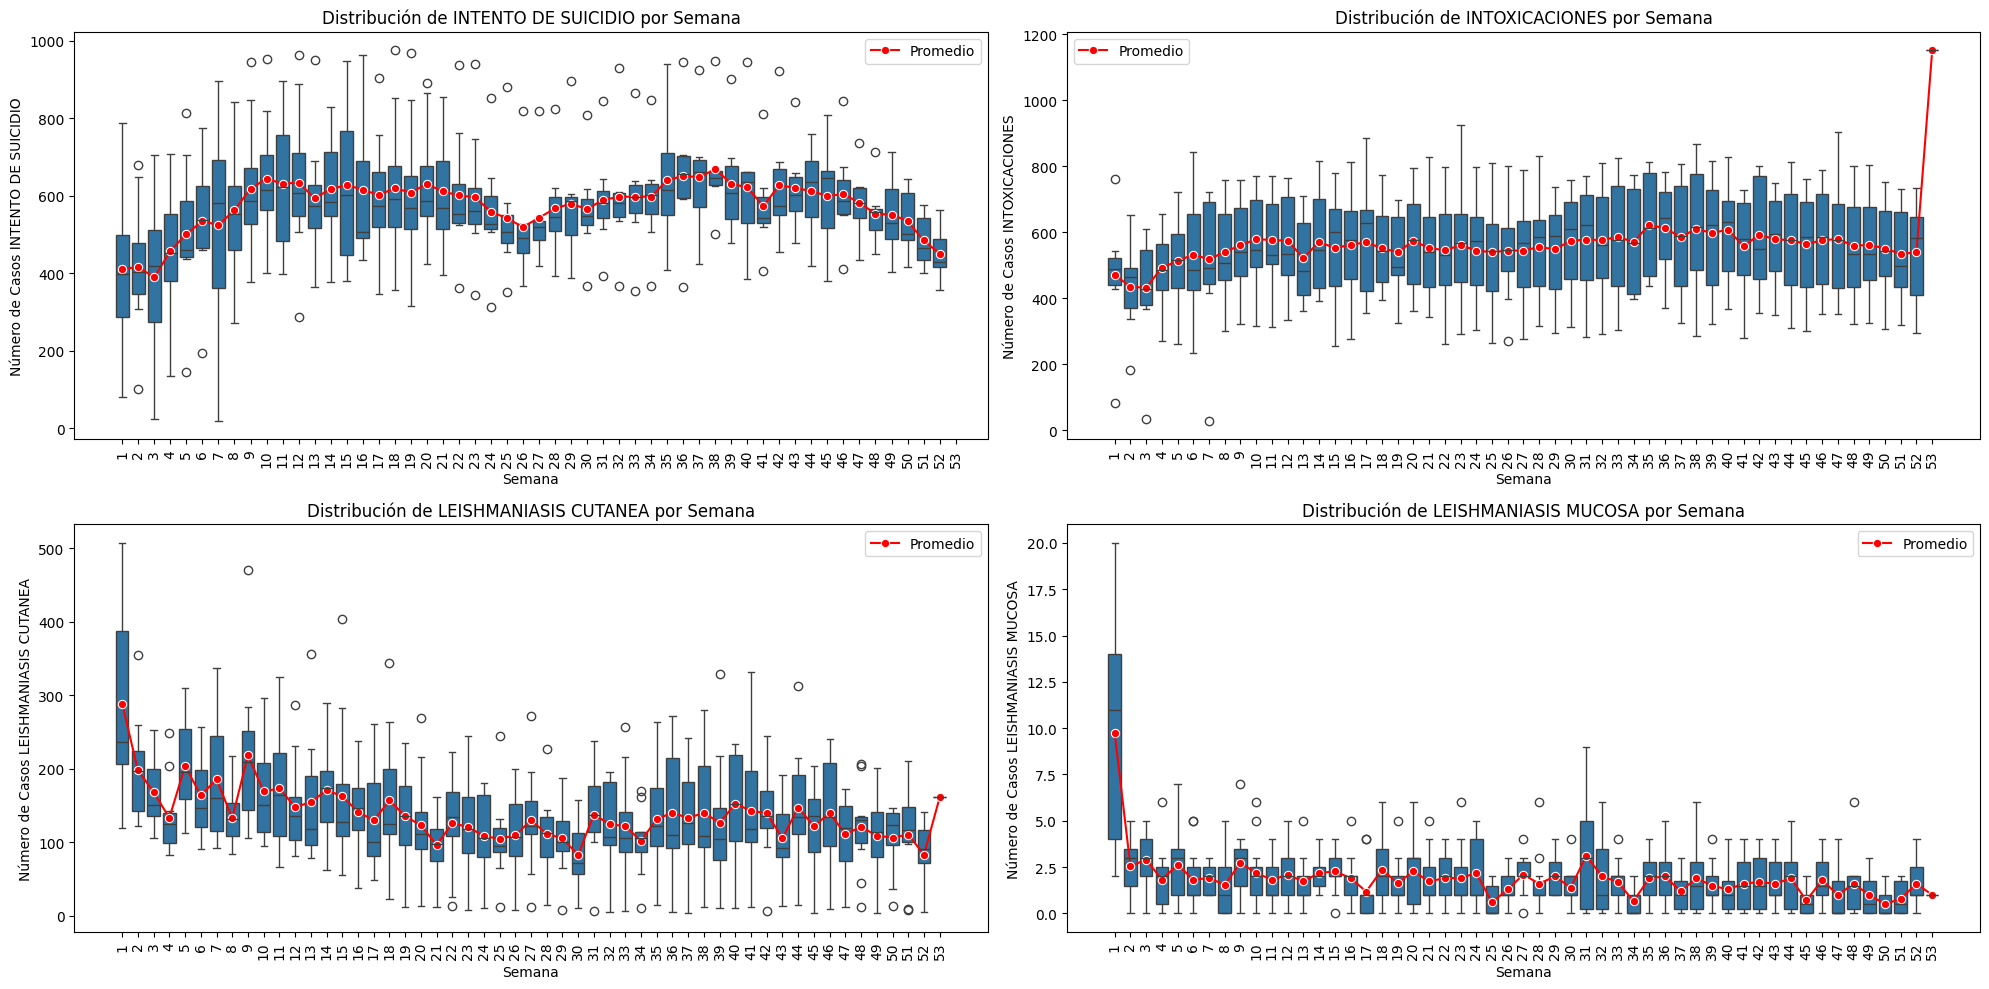

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'LEISHMANIASIS VISCERAL' - 'LEPRA' - 'LEPTOSPIROSIS' - 'LESIONES DE CAUSA EXTERNA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[29:33]

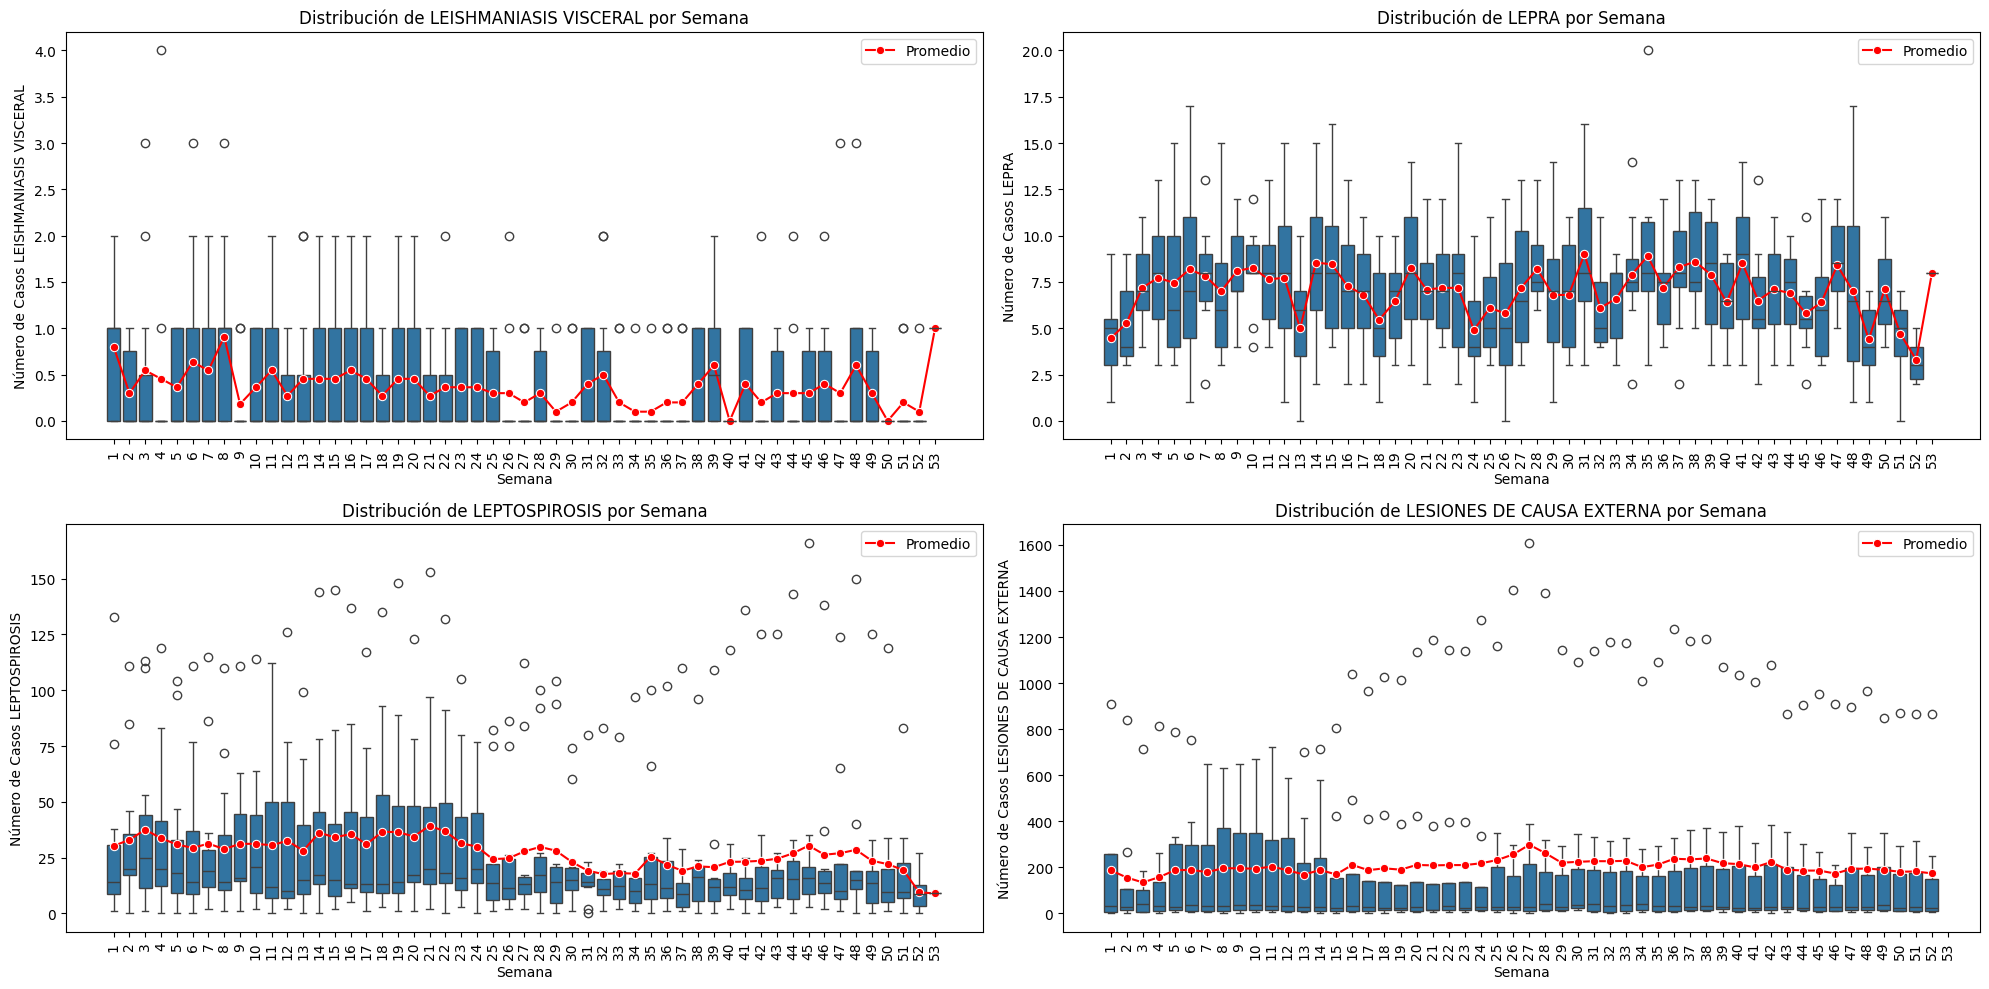

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'LESIONES POR PÓLVORA PIROTÉCNICA' - 'MALARIA' - 'MENINGITIS BACTERIANA Y ENFERMEDAD MENINGOCÓCICA' - 'MORBILIDAD MATERNA EXTREMA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[33:37]

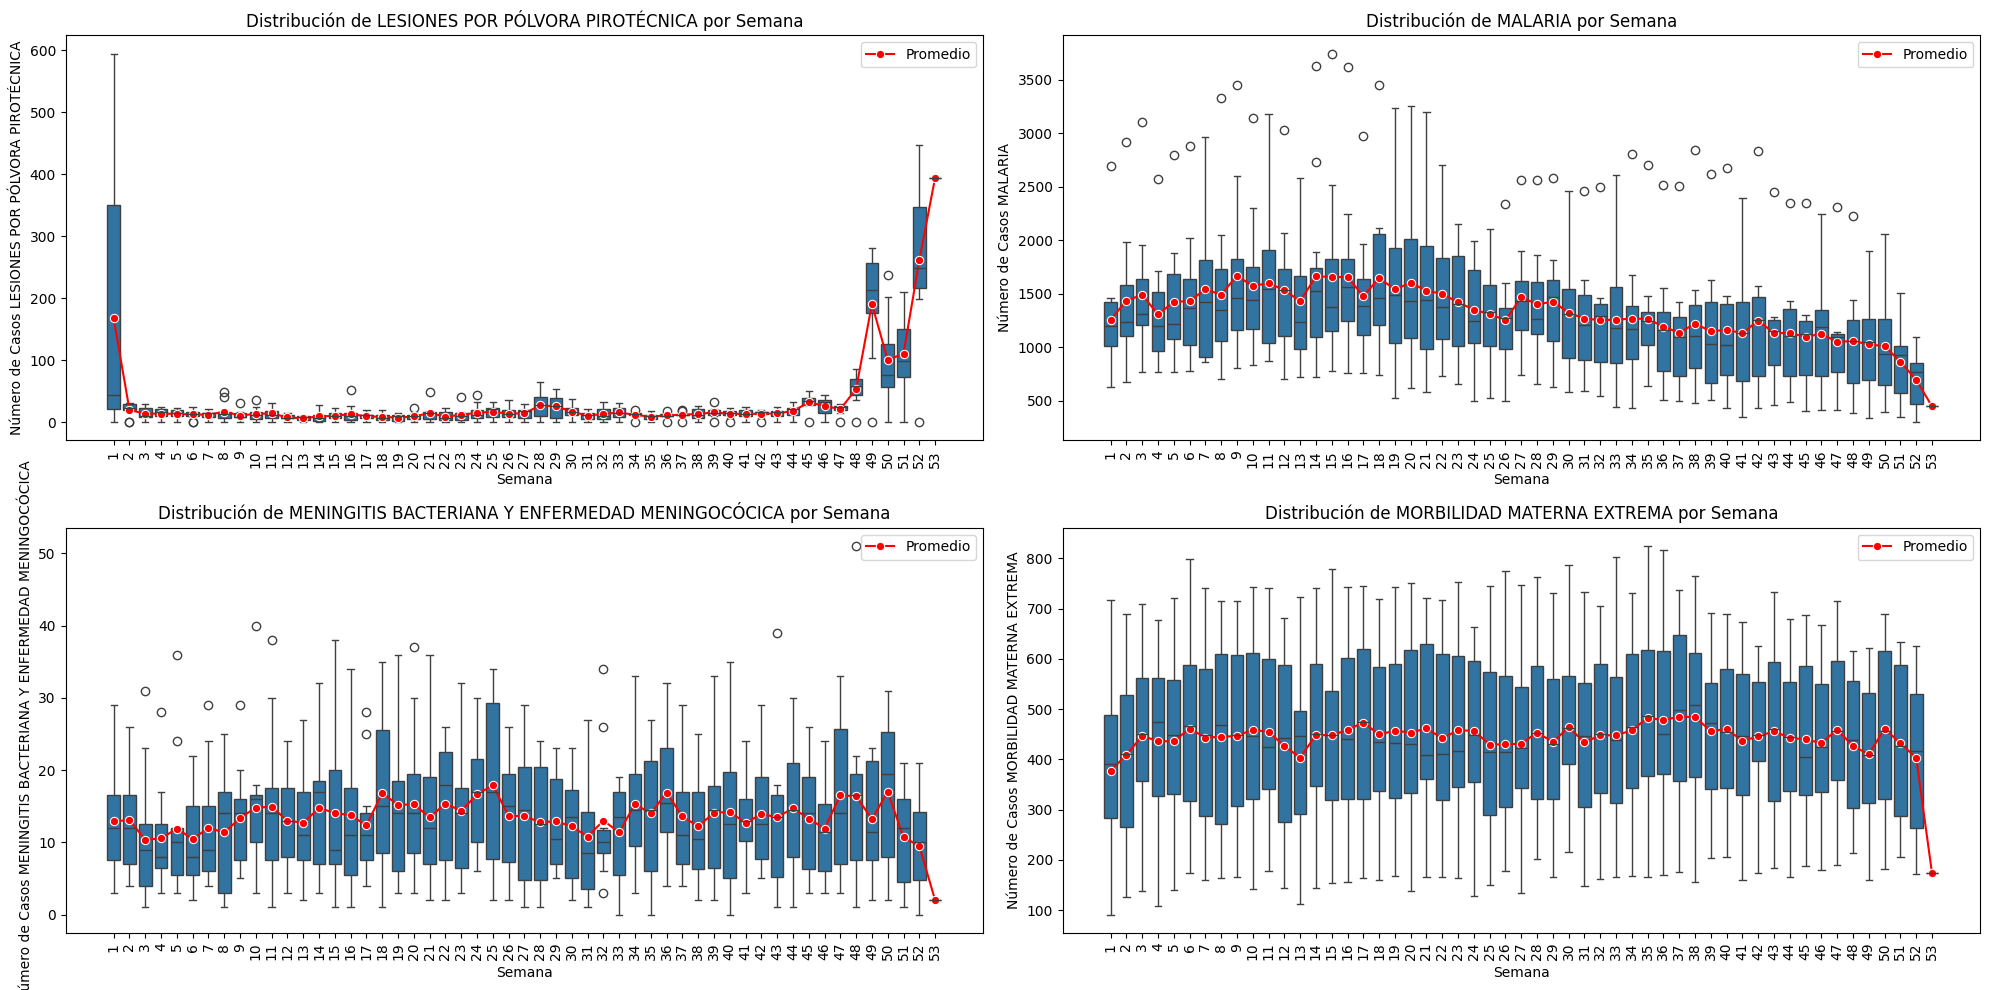

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'MORTALIDAD MATERNA ' -  'MORTALIDAD PERINATAL Y NEONATAL TARDÍA' - 'MORTALIDAD POR DENGUE' - 'MORTALIDAD POR DESNUTRICIÓN'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[37:41]

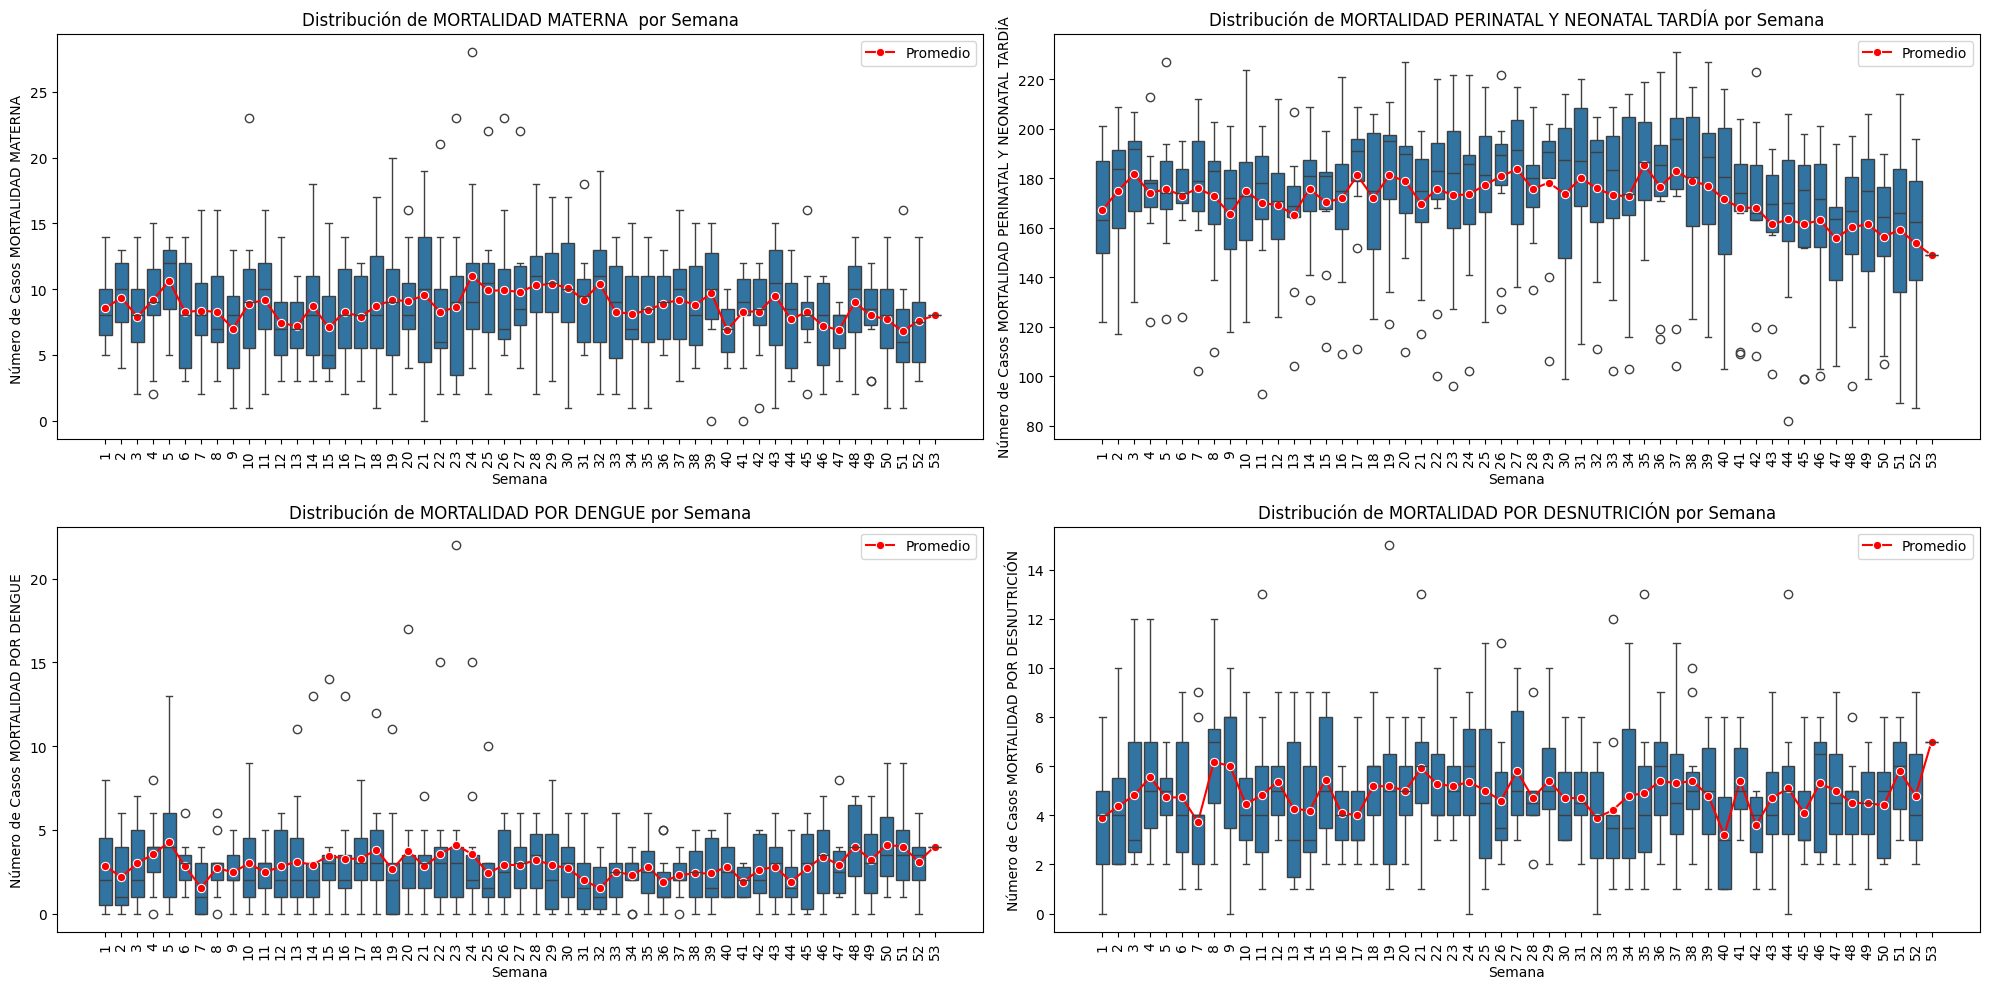

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'MORTALIDAD POR EDA 0-4 AÑOS' - 'MORTALIDAD POR IRA' - 'PAROTIDITIS' - 'SIFILIS CONGENITA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[41:45]

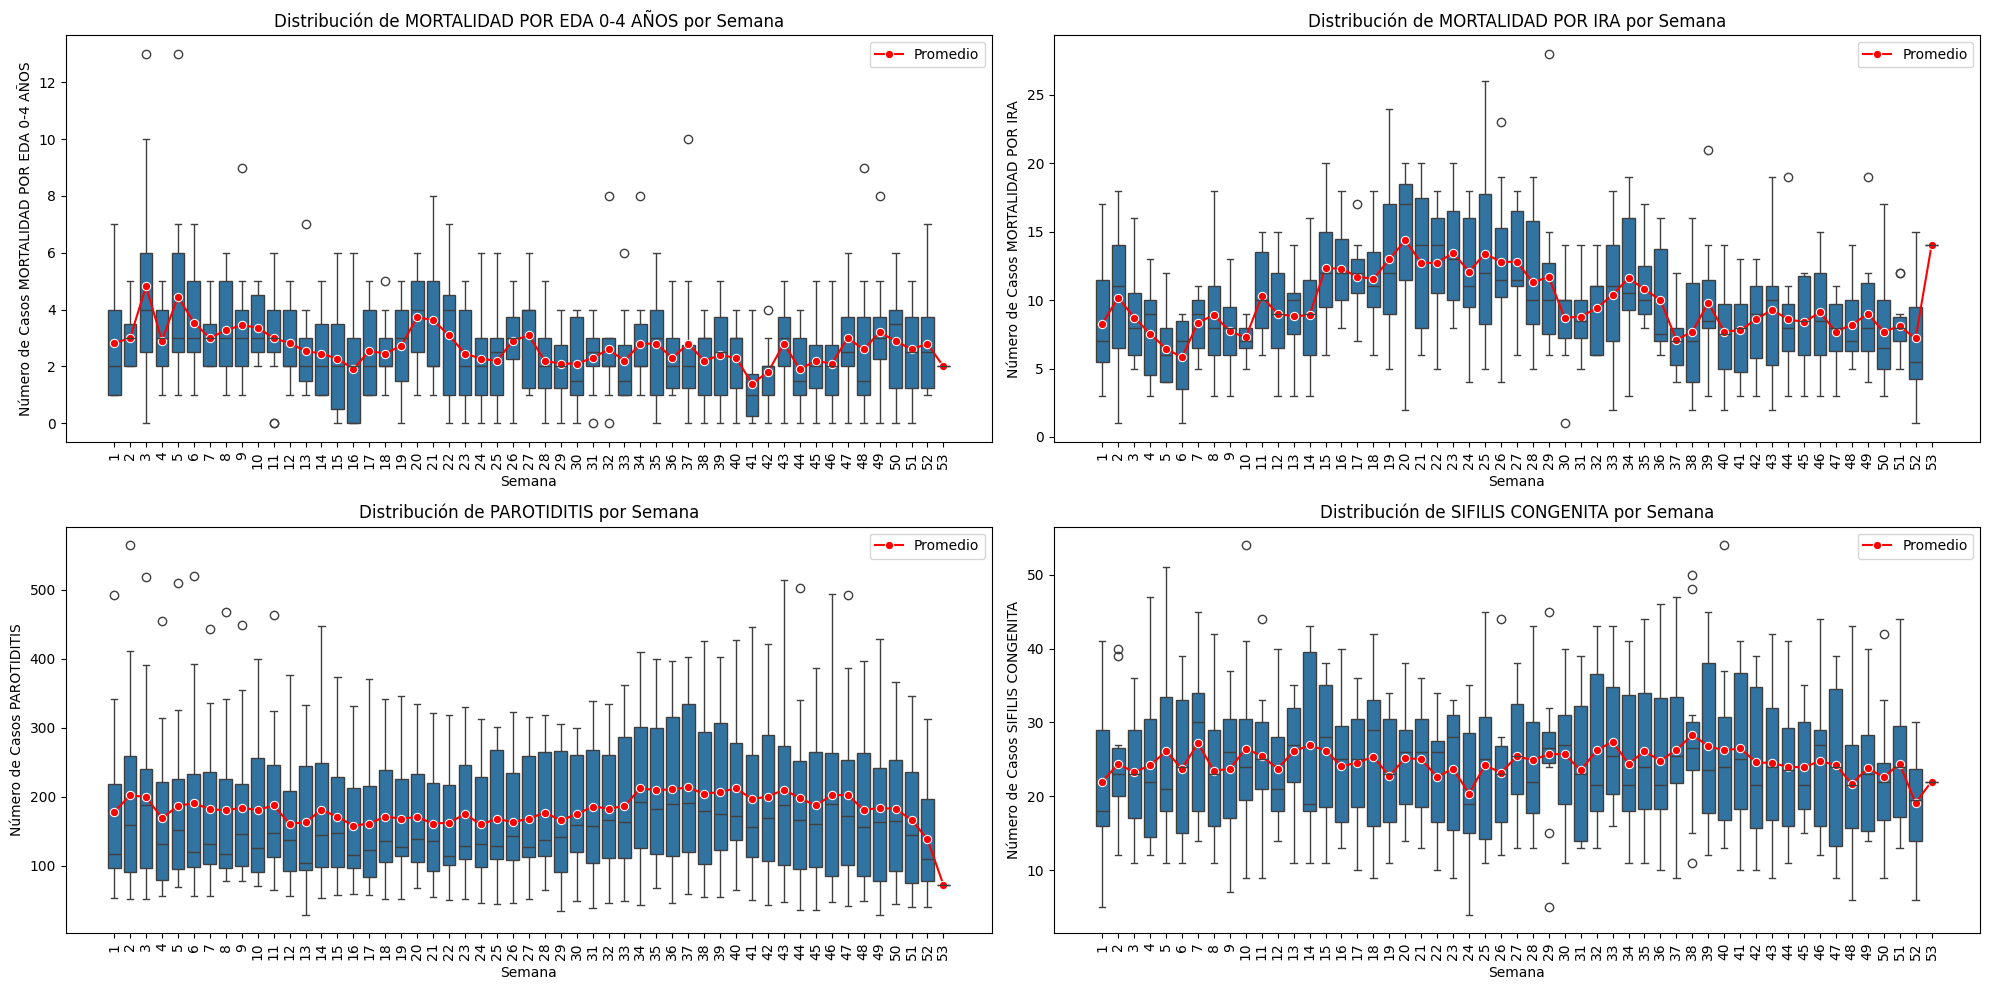

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'SIFILIS GESTACIONAL' - 'TETANOS ACCIDENTAL' - 'TETANOS NEONATAL' - 'TIFUS ENDEMICO TRASMITIDO POR PULGAS']

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[45:49]

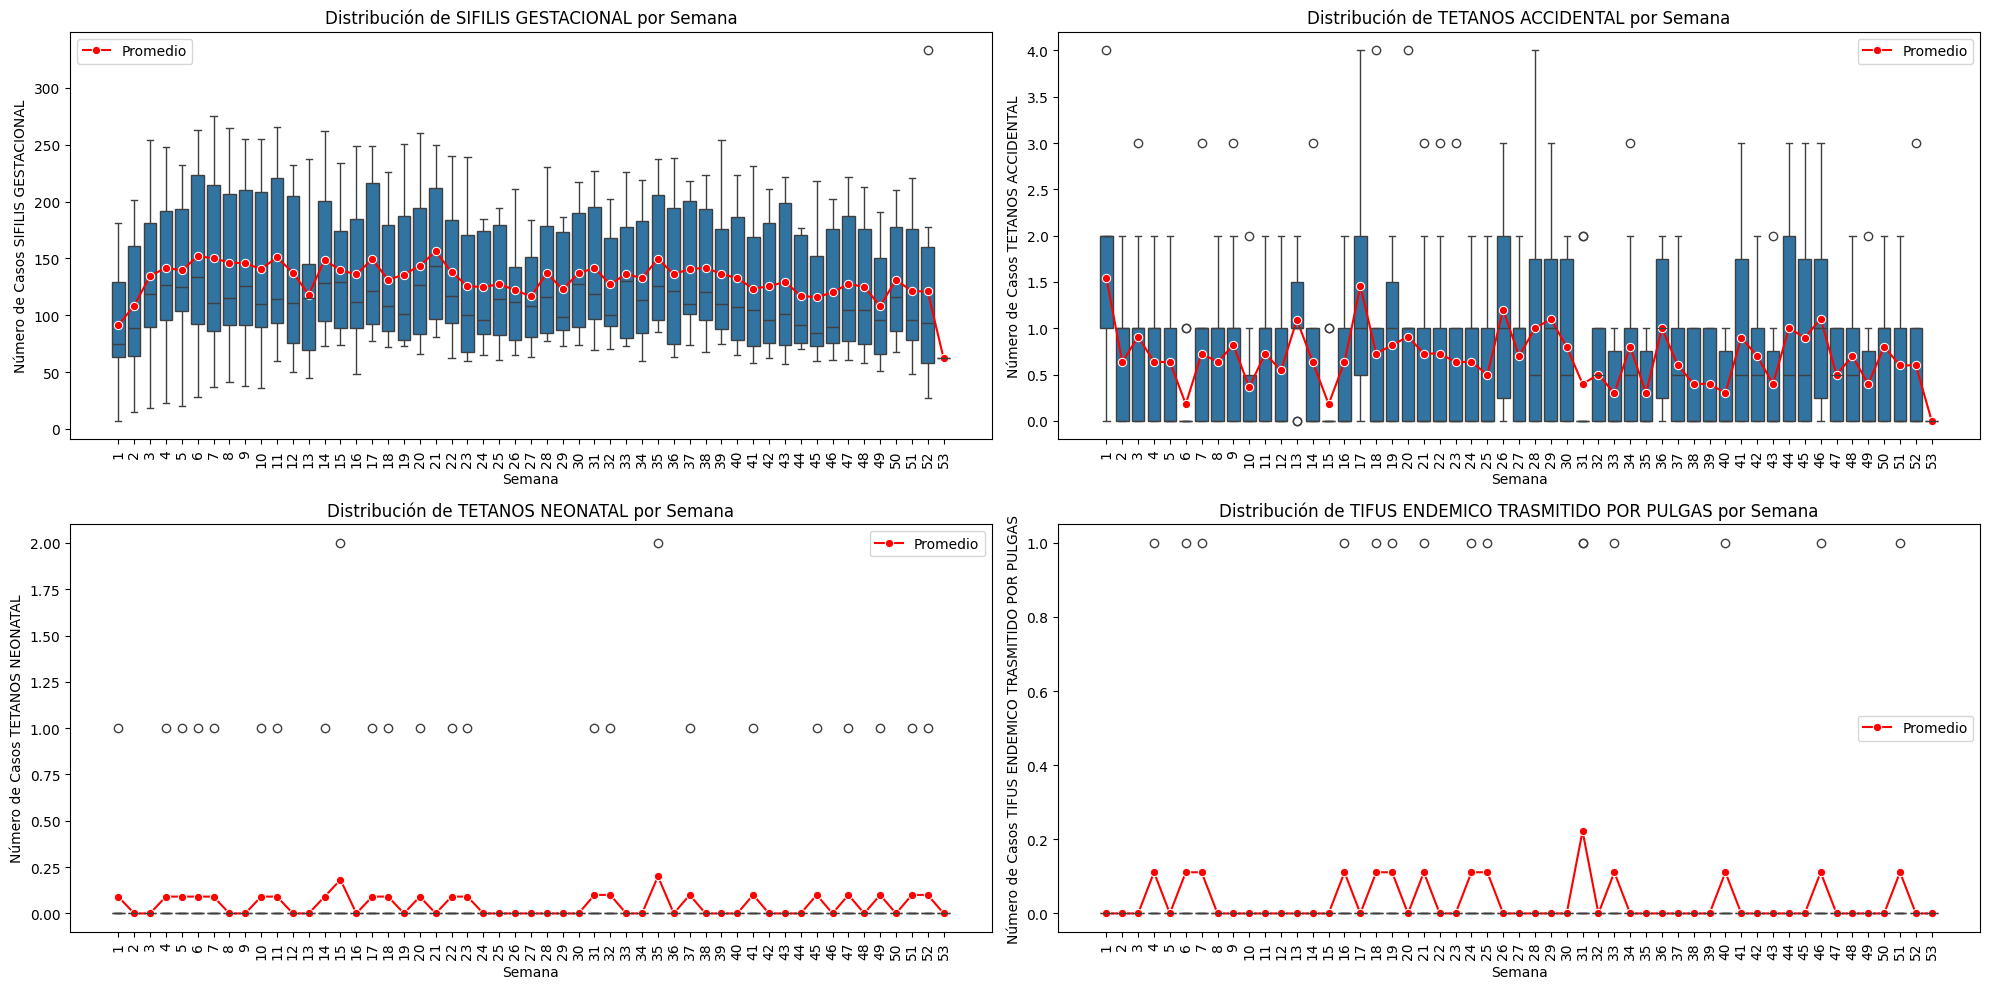

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'TIFUS EPIDEMICO TRANSMITIDO POR PIOJOS' - 'TOS FERINA' - 'TUBERCULOSIS' - 'TUBERCULOSIS FÁRMACORRESISTENTE']


In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[49:53]

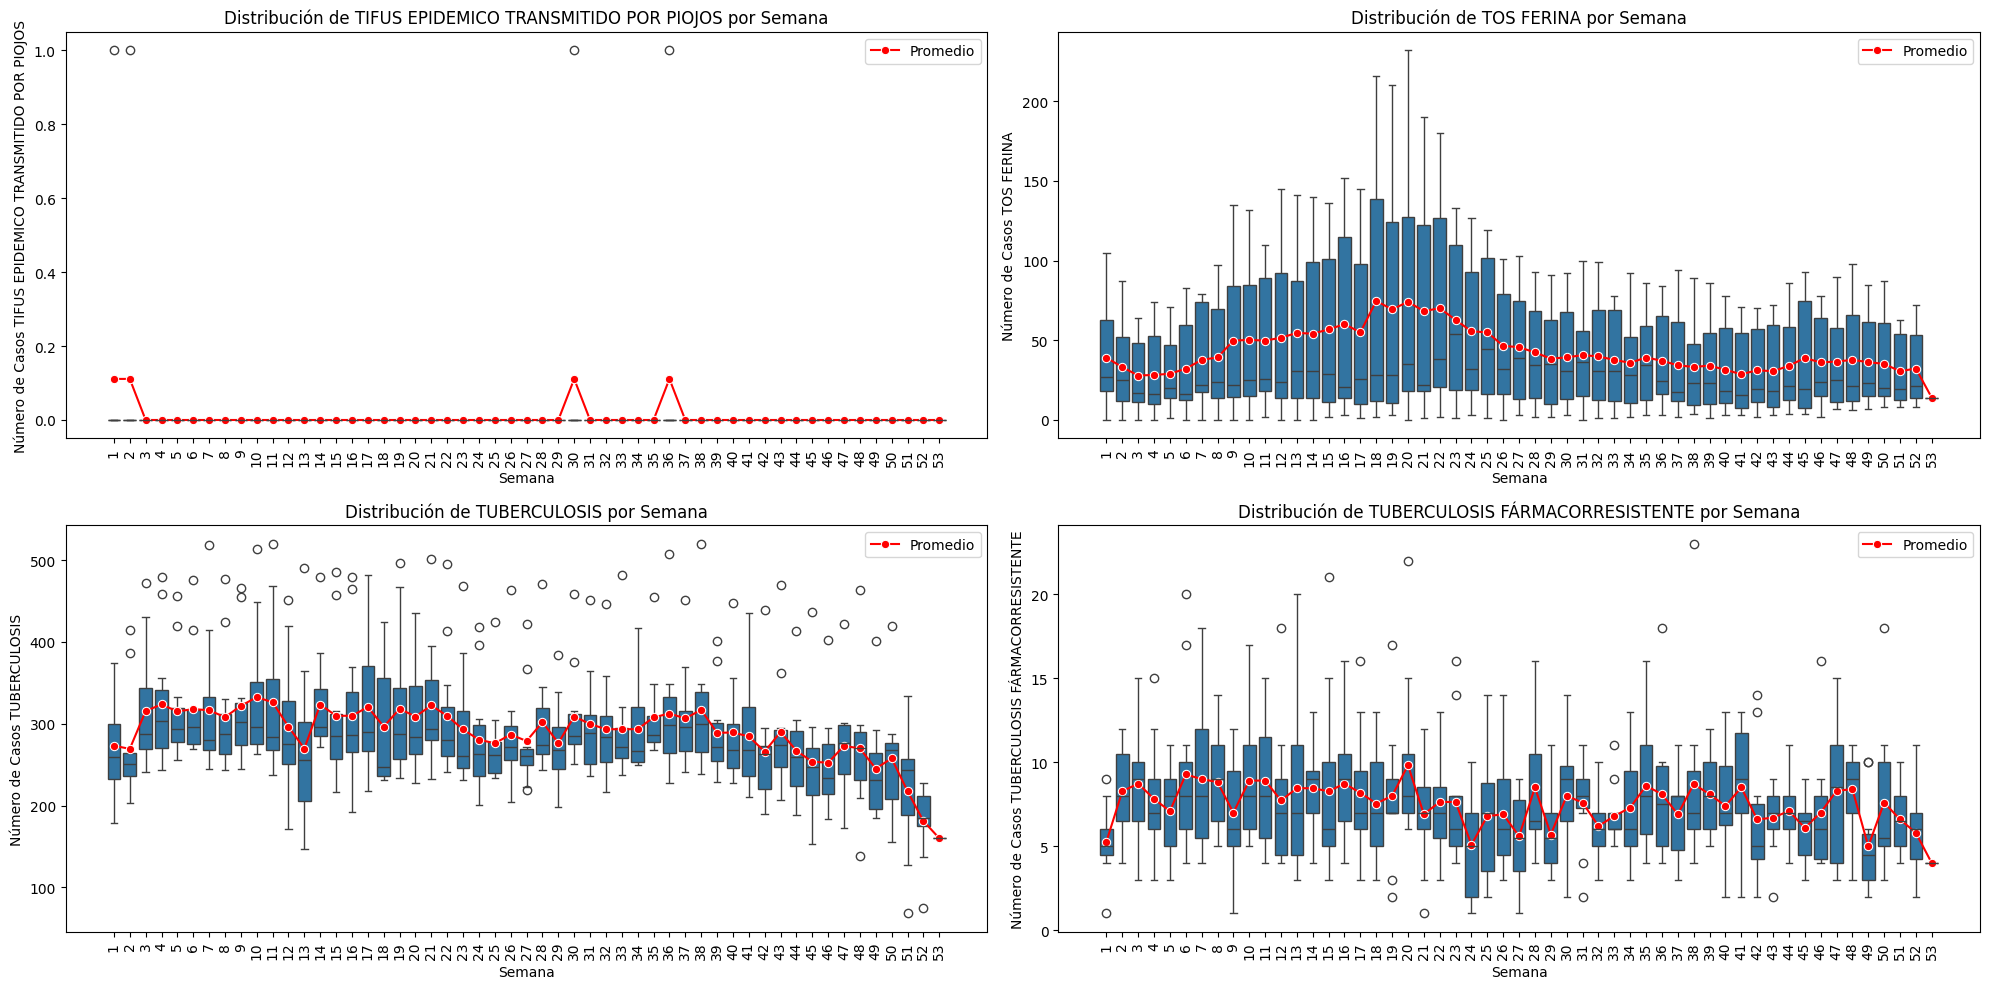

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'VARICELA INDIVIDUAL' - 'VIGILANCIA EN SALUD PÚBLICA DE LA VIOLENCIA DE GÉNERO E INTRAFAMILIAR' - 'VIH/SIDA/MORTALIDAD POR SIDA' - 'HEPATITIS A'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[53:57]

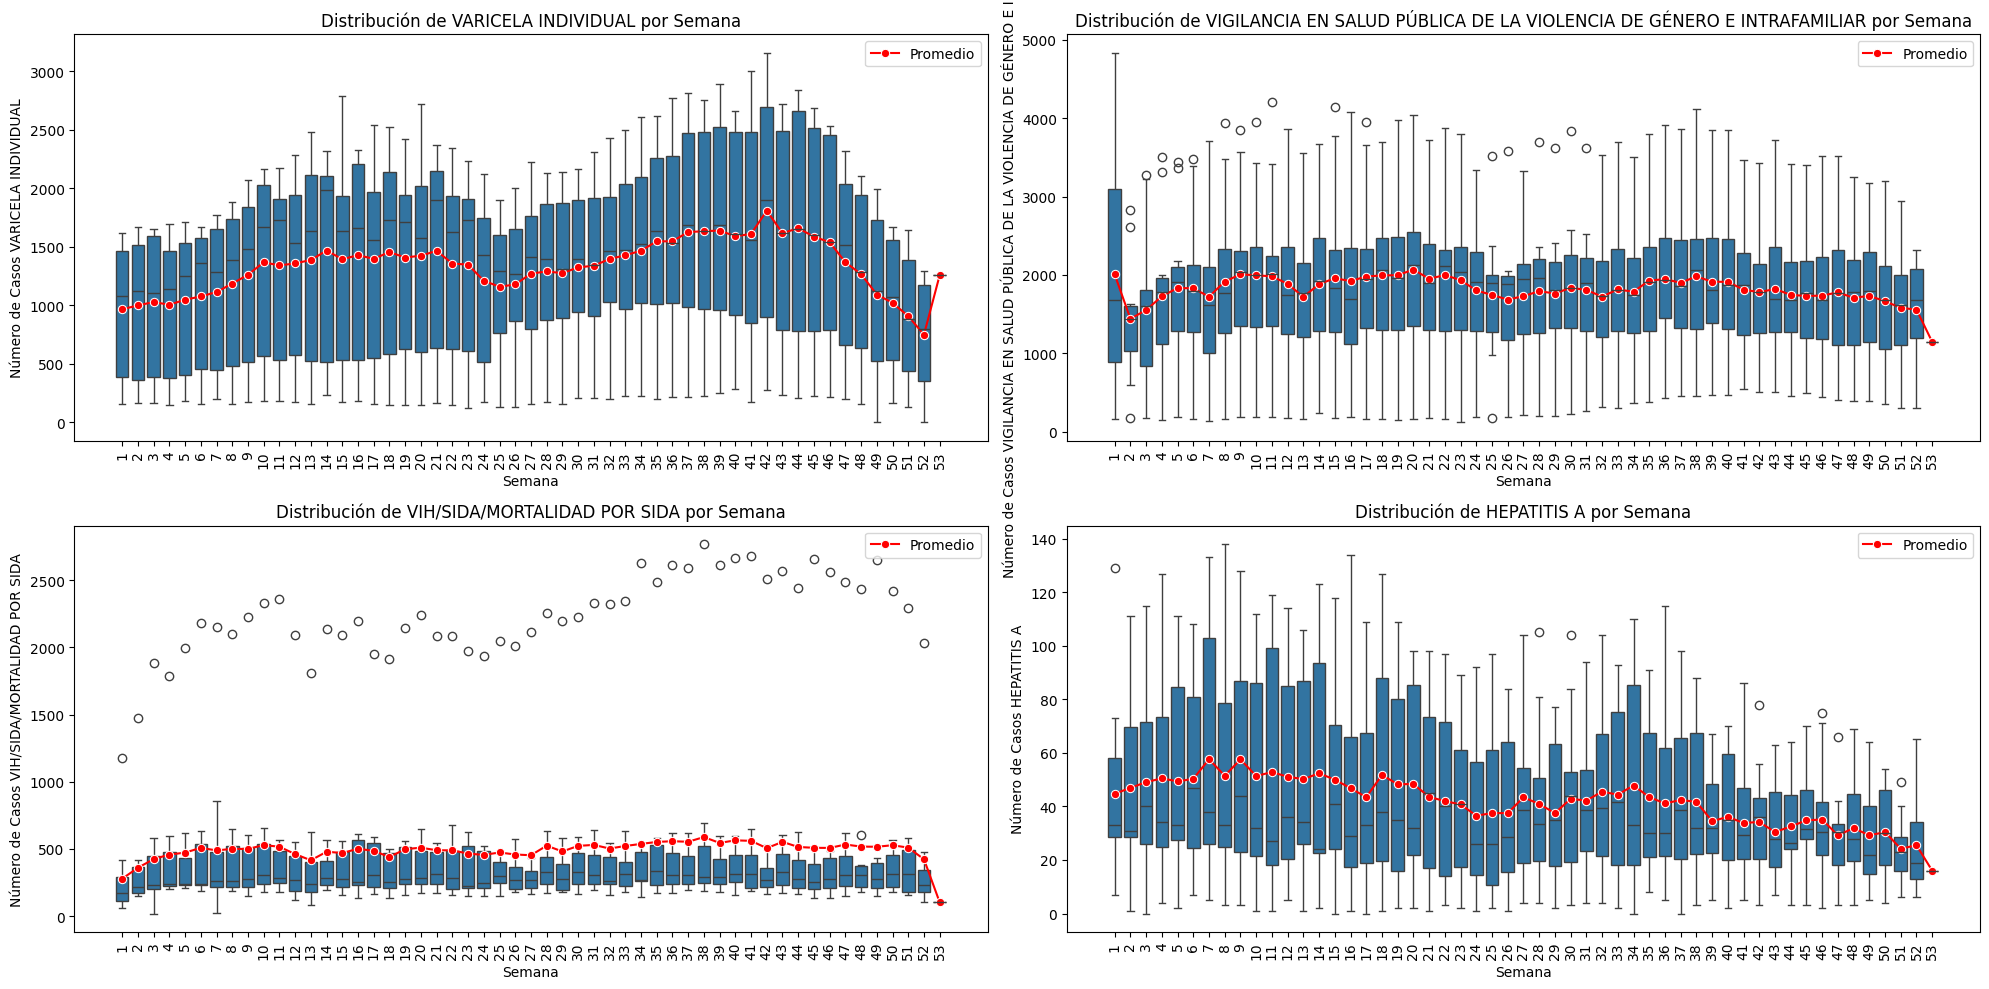

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 'HEPATITIS C' - 'RUBEOLA' - 'SARAMPION + RUBEOLA' - 'ZIKA'

In [ ]:
ETV, ETV2, ETV3, ETV4 = df_eventos.columns[57:61]

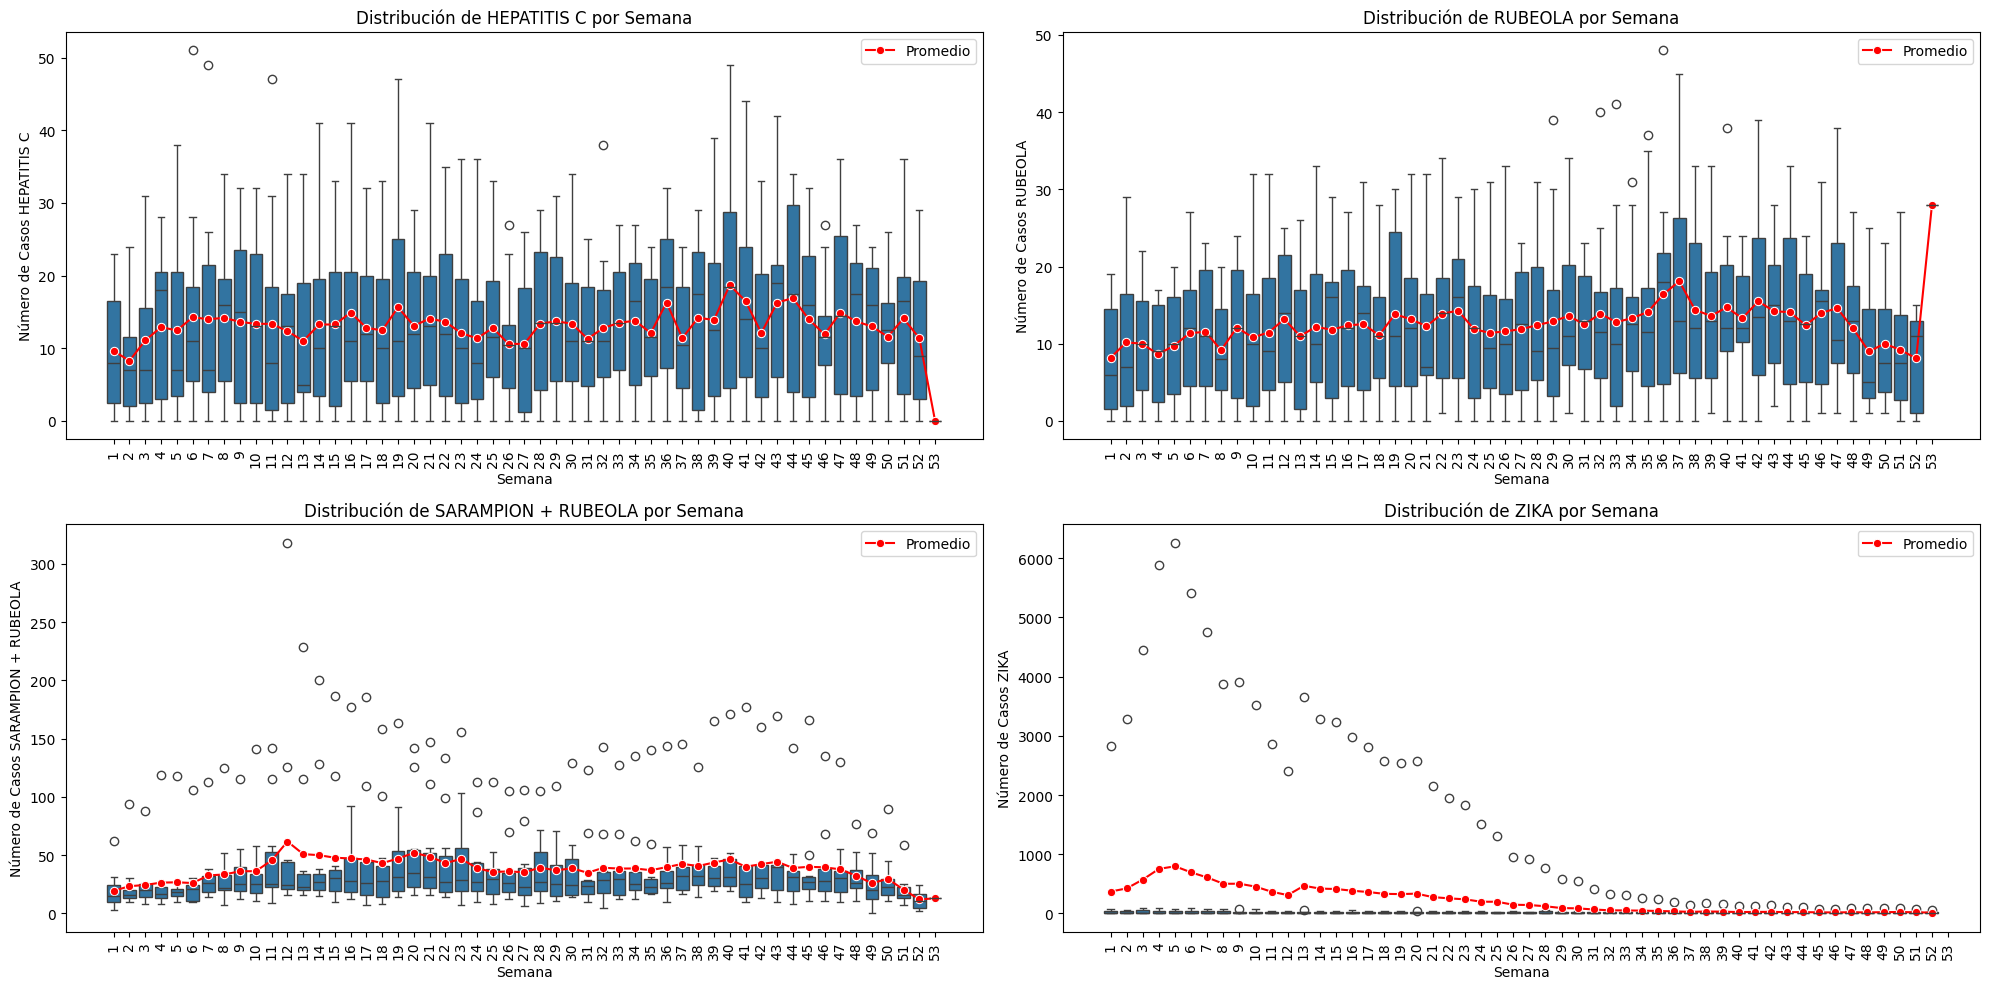

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.boxplot(ax=axes[0,0], x='Semana', y=ETV, data=df_eventos)
weekly_mean_etv = df_eventos.groupby('Semana')[ETV].mean().reset_index()
sns.lineplot(ax=axes[0,0], x='Semana', y=ETV, data=weekly_mean_etv, color='red', label='Promedio', marker='o')
axes[0,0].set_title(f'Distribución de {ETV} por Semana')
axes[0,0].set_xlabel('Semana')
axes[0,0].set_ylabel(f'Número de Casos {ETV}')
axes[0,0].legend()

# Gráfico para ETV2

sns.boxplot(ax=axes[0,1], x='Semana', y=ETV2, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV2].mean().reset_index()
sns.lineplot(ax=axes[0,1], x='Semana', y=ETV2, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[0,1].set_title(f'Distribución de {ETV2} por Semana')
axes[0,1].set_xlabel('Semana')
axes[0,1].set_ylabel(f'Número de Casos {ETV2}')
axes[0,1].legend()

# Gráfico para ETV3

sns.boxplot(ax=axes[1,0], x='Semana', y=ETV3, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV3].mean().reset_index()
sns.lineplot(ax=axes[1,0], x='Semana', y=ETV3, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,0].set_title(f'Distribución de {ETV3} por Semana')
axes[1,0].set_xlabel('Semana')
axes[1,0].set_ylabel(f'Número de Casos {ETV3}')
axes[1,0].legend()

# Gráfico para ETV4

sns.boxplot(ax=axes[1,1], x='Semana', y=ETV4, data=df_eventos)
weekly_mean_etv2 = df_eventos.groupby('Semana')[ETV4].mean().reset_index()
sns.lineplot(ax=axes[1,1], x='Semana', y=ETV4, data=weekly_mean_etv2, color='red', label='Promedio', marker='o')
axes[1,1].set_title(f'Distribución de {ETV4} por Semana')
axes[1,1].set_xlabel('Semana')
axes[1,1].set_ylabel(f'Número de Casos {ETV4}')
axes[1,1].legend()

# Rotar etiquetas del eje X para ambos gráficos
for ax in axes.flatten():
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()